# Single Run Analysis

This notebook takes a single output of the 2D_SI_DNS dedalus run. Makes descriptive plots for the manuscript.

Author: Jacob Wenegrat
12-02-2019

In [621]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Load variables

In [622]:
#%% Pick the filename and path

###################### CI RUN ############################
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope

NameAppend='CI-1'
visc = 1e-4
Vi = 0.1

###################### SI RUN ############################
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5' #Ruan case F
#NameAppend='SI-1'
#visc = 1e-4
#Vi = 0.1

################## CONVECTIVE RUN ###########################
#ilename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005_MS.h5' #Ruan case F
#NameAppend='CONV-1'
#visc = 1e-4
#Vi = 0.1

###################### CHECKING RUNS ############################
#filename ='/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5'
#NameAppend='TEST-1'
#visc = 1e-4
#Vi = 0.1

SAVEFLAG = False # Turn on to savefigs



f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'][0,0,0] # Slope angle

S2 = N**2*tht**2/1e-8
# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w'] # Slope-normal direction
b = f['tasks']['b'] # Perturbation buoyancy

qa = f['tasks']['PVa']
q = f['tasks']['PV']
wq = f['tasks']['wq']
# Energy terms 
gsp = f['tasks']['GSP']
gspr = f['tasks']['GSProtated']
vspu = f['tasks']['VSPu']
vspv = f['tasks']['VSPv']
vsp = vspu[:,:,:]+vspv[:,:,:]
lspu = f['tasks']['LSPu']
lspv = f['tasks']['LSPv']
lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
vbf = f['tasks']['VBF']
vbfr = f['tasks']['VBFr']
hbfr = f['tasks']['HBFrotated']
hbfr = hbfr*np.sin(tht)
vbfrot = f['tasks']['VBFrotated']
SP = f['tasks']['SP']
EKE = f['tasks']['EKE']
try:
    upwp = f['tasks']['UPWP']
    vpwp = gspr[:,0,:]*1e-4/(N**2*np.sin(tht))
    # SPECTRAL QUANTITIES
    ws = f['tasks']['ws']
    bs = f['tasks']['bs']
    vs = f['tasks']['vs']
except:
    ws = f['tasks']['wcs']
    bs = f['tasks']['bs']
    vs = f['tasks']['vcs']
    print('Could not load flux terms')



# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

In [623]:
#Function to find convective and low PV layer depth
def findH(q, Qint, wpbp, z, crit=0.5):
    #low PV layer
    indq = np.where(q>crit*Qint)[0][0]
    H = z[indq]

    #convective layer
    #inds = np.where(np.logical_and(np.logical_and(wpbp>0, z<=H*0.9), z>10))[0]
    zm = 0.5*(z[1:]+z[0:-1])

    inds = np.where(np.logical_and(np.diff(np.signbit(wpbp)), np.logical_and(zm>1, zm<H*0.5)))[0]
    if inds.size == 0:
        inds = np.where(np.logical_and(np.diff(np.signbit(wpbp)), 0.5*(z[1:]+z[0:-1])<H))[0]

    if inds.size == 0:
        print('No Ind ' )
        h = H
    else:
#        inds = [inds[-1]]
        inds = [inds[0]]

        h = z[inds[0]]
    return H, h

def findHScale(H, usy, Vgz, Bek, vbf, z, S2): # Assume at one time point
    indH = np.argmin(np.abs(H-z))
    wpbph = vbf[indH]
    entfact = 1-wpbph/np.abs(Bek)/(1+S2)
    print(entfact)
    def f(x):
        return x**4 - 8.3**3*(usy/(H*Vgz))**4*(1-entfact*x)**3

    hall, info, ier, n = optimize.fsolve(f, 0.6, maxfev=100000, full_output=True)
    h = hall
    if ier != 1:
            h = 0
            print(n)
    if np.logical_or(h<=0, h>1):
        h = np.nan
    return h*H



In [624]:
# Calculated quantities
va = np.mean(v, axis=1)

qm = np.mean(q, axis=1) 
bm = np.mean(b, axis=1)
bxc = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :,np.newaxis], axis=1)*np.cos(tht)- np.gradient(b, axis=-1)/np.gradient(z[np.newaxis, np.newaxis,:], axis=-1)*np.sin(tht) #f['tasks']['bxs']
bx = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :, np.newaxis], axis=1)
bxcm = np.mean(bxc, axis=1)
bxm = np.mean(bx, axis=1)

bzr = np.gradient(bm, axis=-1)/np.gradient(z)*np.cos(tht) + bxcm*np.sin(tht) + N**2

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
up = u - um[:,np.newaxis,:]
vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(np.mean(w, axis=1), axis=-1)/np.gradient(z)
zm = z-z[-1]
qt = np.transpose(np.transpose(np.gradient(qm, axis=0))/np.gradient(time))
qta = np.gradient(qa[:,0,0])/np.gradient(time)
bb = x[np.newaxis,:,np.newaxis]*N**2*np.sin(tht) + N**2*np.cos(tht)*z[np.newaxis, np.newaxis,:]
bf = b + bb
bz = np.gradient(bm, axis=-1)/np.gradient(z) + N**2
bz_prime = np.gradient(bm, axis=-1)/np.gradient(z)
Ri = bz/(uz**2 + vz**2)



#zetaprimebprime = np.mean((bf - np.mean(bf,axis=1))*(np.gradient(v, axis=1)/np.gradient(x)), axis=1)
uz = np.gradient(u, axis=-1)/np.gradient(z)
vz = np.gradient(v, axis=-1)/np.gradient(z)
EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKE = 0.5*(um**2 + (vm)**2)
MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# SPECTRAL
try:
    gsps = 2*np.real(-np.conj(vs)*ws*bxcm[:,np.newaxis,:]/1e-4)
    vbfs = 2*np.real(np.conj(ws)*bs)
    wbs = 2*np.real(np.conj(ws)*bs)
    wvs = 2*np.real(np.conj(ws)*vs)
except:
    print('Could not calculate spectral fluxes.')

/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


In [625]:
# Divide into high/low wavenumber (nt x nz)
kcut = np.where(kx<1/100)[0]
kcut = kcut[-1]
gsps = -wvs*N**2*tht/(1e-4)
vbfs = wbs
gspl = np.sum(gsps[:,1:kcut,:], axis=1)
gsph = np.sum(gsps[:,kcut:,:], axis=1)
vbfl = np.sum(vbfs[:,1:kcut,:], axis=1)
vbfh = np.sum(vbfs[:,kcut:,:], axis=1)

vbfh.shape

(1920, 256)

## Estimate bottom stress and Ekman transport

The bottom stress is needed to calculate the cross-slope Ekman transport. 
There are several ways to calculate this. The first is directly, given that we resolve the viscous layer ($\delta_v = \nu/u^*$).
\begin{equation}
\tau_y = \rho \nu \frac{\partial v}{\partial z}
\end{equation}
where $\nu$ is the subgrid viscosity.

The other way (which would in some sense be preferable for observational purposes, would be using a drag coefficient:
\begin{equation}
\tau_y = \rho C_d \sqrt{u^2 + v^2}v
\end{equation}
This appears to work reasonably well, however it has to be evaluated on the order of meters above the bottom. Not sure how this is supposed to actually be evaluated (ie. is there a principled way to pick the depth?).

Using these the cross-slope Ekman transport is given by,

\begin{equation}
B_{Ek} = \frac{\tau_y}{\rho_o f(1+S^2)} N^2 \sin{\theta}
\end{equation}

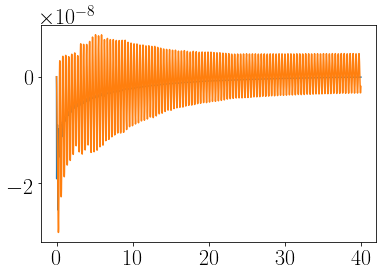

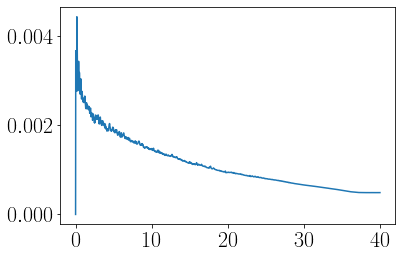

In [626]:
uss = visc*np.sqrt(np.mean(uz[:,:,0]**2 + vz[:,:,0]**2, axis=1))
us = np.sqrt(uss)
usm = np.mean(us)
delv = visc/usm

tauy = -1035*visc*np.mean(vz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS
taux = -1035*visc*np.mean(uz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS


# Calculate the Ekman transport using bottom stress:
Beka = tauy/(1030*1e-4*(1+S2))*N**2*np.sin(tht)

# Alternately calculate the actual cross-slope buoyancy transport
Ubar = integrate.trapz(um,x=zm, axis=-1 )
BekD = Ubar*N**2*np.sin(tht)
#Bek = Beka
# Compare estimates of bottom transport
plt.plot(time/86400, Beka)
plt.plot(time/86400, BekD)

plt.figure()
plt.plot(time/86400, us)

/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


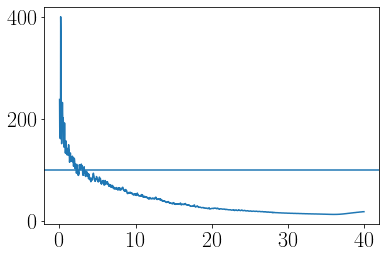

In [627]:
# Look at Slope Monin Obukhov Length as in Ruan et al. 2019
Lo = us**3/(0.4*-Beka)
zs = visc/us
plt.plot(time/86400, Lo/zs)
plt.axhline(100) # Approximate relaminarization point

/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(-199.99623505652022, -194.99623505652022)

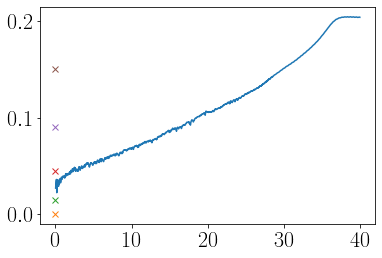

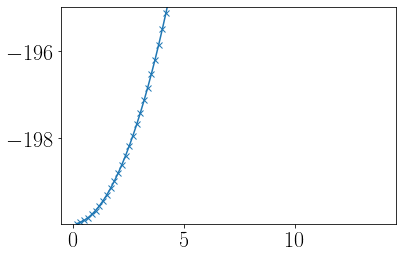

In [628]:
# Plot resolution inside the viscous layer (note Ruan et al. 2019 uses 2 points in 5*deltav)
plt.figure()
plt.plot(time/86400, visc/us)
plt.plot(0, np.transpose(zm[0:5,np.newaxis] - zm[0]), marker='x');

# Plot delta z normalized by viscous units
deltaz = zm[1:] - zm[:-1]
plt.figure()
plt.plot(deltaz/delv, zm[1:], marker='x')
plt.ylim((zm[0], zm[0]+5))

## Calculate the 0 PV layer depth (H)

This code calculates the depth of the zero PV layer using:
\begin{equation}
\frac{\partial H^2}{\partial t} = 2 \frac{B_{Ek}(t)}{N^2}
\end{equation}

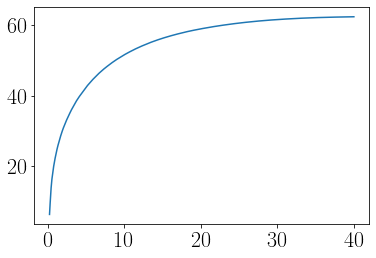

In [629]:
nt = BekD.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 12
Ho = 5
Ent = 1
#toff = 48*2
#Ho = 50
#Ent = 1.6 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*(1+S2)*Ent*-Beka[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)

## Calculate the convective layer depth

See manuscript for details (parameters are hardcoded here from best fits)

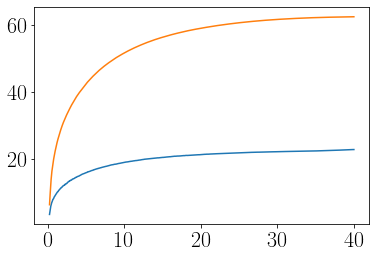

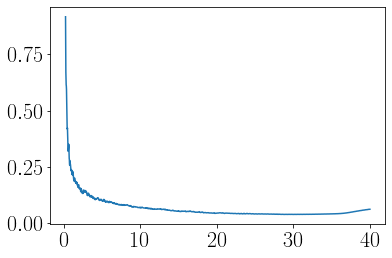

In [630]:
def fithT(ent, H):
    def fithH(factor): #factor is the combined coefficient of the highest order term (ie. Factor*(1-h/h)^3)
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            def f(x):
              return (x-0.35)**2 - 0.1*factor[i]**2*(1-ent[i]*x)

            if np.isfinite(factor[i]):
                h[i], info, ier, n = optimize.fsolve(f, 0.35, maxfev=10000, full_output=True)
                if ier == 0:
                    print('fail')
        return h*H
    return fithH

fact = Lo/H
h = fithT(0*H + 1, H)(fact)
plt.plot(time/86400, h)
plt.plot(time/86400, H)

plt.figure()
plt.plot(time/86400, fact)

## COMPARE CONV TO SCALING

No Ind 


/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


(0, 70)

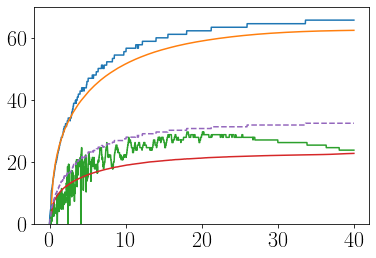

In [631]:
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
hscale = np.zeros((nt,))
ent = np.zeros((nt,))
for i in range(0, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z)
    indh = np.argmin(np.abs(hnum[i] - z))
    ent[i] = 1-vbfrot[i,0,indh]/Beka[i]
    hscale[i] = (+visc*bz[i,indh] + Beka[i] - vpwp[i,indh]*N**2*tht/(1e-4*(1+S2)))/(ent[i]*Beka[i]+1e-4*N**2)*Hnum[i]
    #hscale[i] = (Beka[i] - vpwp[i,indh]*N**2*tht/(1e-4*(1+S2)))/(ent[i]*Beka[i])*Hnum[i]
    #htest[i] = np.sqrt(visc*bz[i,indh]/((N**2*tht/(1e-4*(1+S2)))**3))*Hnum[i]
htest = np.sqrt(visc*(1+S2)**2/(N*np.sqrt(S2)))*Hnum
plt.plot(time/86400, Hnum)
plt.plot(time/86400, H)
plt.plot(time/86400, hnum)
plt.plot(time/86400, h)
plt.plot(time/86400, htest, linestyle='--')

#plt.plot(time/86400, hscale)
plt.ylim(0, 70)

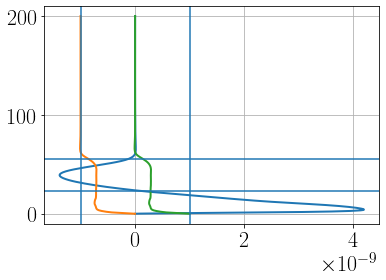

In [632]:
ti = np.where((time/86400>9) & (time/86400<11))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

bza = np.mean(bz[ti,:]-N**2, axis=0)
VISC = np.mean(vbfrot[ti,0,:], axis=0)
#ax[0].plot(TEND, z,linewidth=2, label=r'$\langle b \rangle_t$')

plt.plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle b^\prime w^\prime\rangle}{\partial z} +\kappa \frac{\partial ^2 \langle b \rangle}{\partial z^2}$')
plt.plot(-visc*(bza+N**2), z,linewidth=2, label=r'$\nu \frac{\partial \langle b \rangle}{\partial z}$')
plt.plot(-visc*(bza), z,linewidth=2, label=r'$\nu \frac{\partial \langle b \rangle}{\partial z}$')

plt.axvline(-visc*N**2)
plt.axvline(visc*N**2)
plt.grid()
plt.axhline(hnum)
plt.axhline(Hnum)

No Ind 


/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


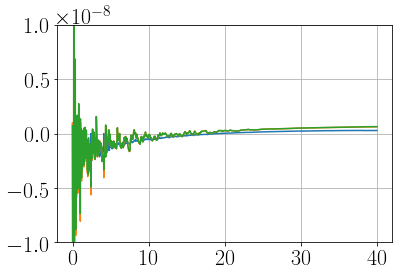

In [633]:
# Look at convective equation LHS vs RHS
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
LHS = np.zeros((nt,))
RHS = np.zeros((nt,))
RHSp = np.zeros((nt,))
for i in range(0, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z);
    indh = np.argmin(np.abs(hnum[i] - z))
    indH = np.argmin(np.abs(Hnum[i] - z))
    ent[i] = 1-vbfrot[i,0,indH]/Beka[i]
    LHS[i] = hnum[i]/Hnum[i]*(Beka[i] + visc*(0*N**2 + bz[i,indH]) + 0*visc*N**2*S2/(1+S2))
    RHS[i] = (+visc*bz[i,indh] + Beka[i] - vpwp[i,indh]*N**2*tht/(1e-4*(1+S2)))
    RHSp[i] = (+visc*N**2*S2/(1+S2) + Beka[i] - vpwp[i,indh]*N**2*tht/(1e-4*(1+S2)))

    #hscale[i] = (Beka[i] - vpwp[i,indh]*N**2*tht/(1e-4*(1+S2)))/(ent[i]*Beka[i])*Hnum[i]
tn = time/86400
plt.plot(tn, LHS)
plt.plot(tn, RHS)
plt.plot(tn, RHSp)

plt.ylim(-10e-9, 10e-9)
plt.grid()

In [634]:
print(np.sqrt(visc*(1+S2)**2/(np.sqrt(N**2*S2))))
Vgz = N**2*tht/(1e-4*(1+S2))
print(np.sqrt(visc*N**2*S2/((1+S2)*Vgz**3)))

0.4949747468305833
0.4949747468305835


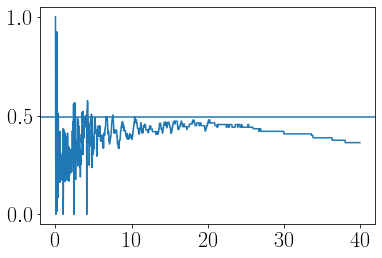

In [635]:
plt.plot(time/86400, hnum/Hnum)
plt.axhline(np.sqrt(visc*(1+S2)**2/(np.sqrt(N**2*S2))))

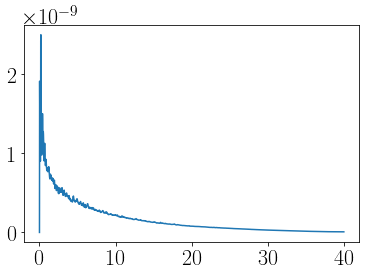

In [636]:
plt.plot(time/86400, -Beka/visc*N**2)


(-2e-10, 2e-10)

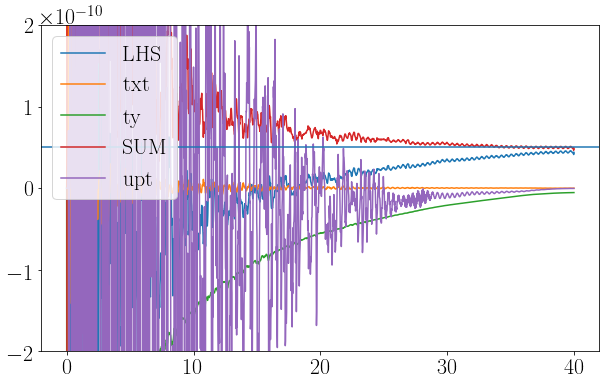

In [637]:
# Brink and Lentz mom balance
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
uterm = np.zeros((nt,))
accel = np.zeros((nt,))
txt = np.zeros((nt,))
upterm = np.zeros((nt,))
upwpt = np.gradient(upwp[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)
ut = np.gradient(um, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
utt = np.gradient(ut, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
txt = np.gradient(taux)/np.gradient(time)
for i in range(1, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z)
    indh = np.argmin(np.abs(hnum[i] - z))
    uterm[i] = 1e-8*(1+S2)*np.trapz(um[i,0:indh], x=z[0:indh])
    accel[i] = np.trapz(utt[i,0:indh], x=z[0:indh])
    txt[i] = -1/1030*txt[i]
    upterm[i] = -(upwp[i,0,indh] - upwp[i-1,0,indh])/(time[i]-time[i-1])
    upterm[i] = np.trapz(-upwpt[i,0:indh], x=z[0:indh])
tyt = 1/1030*1e-4*tauy
bfterm = visc*N**2*tht
tn = time/86400
plt.figure(figsize=(10,6))
#plt.plot(tn, uterm, label='U')
#plt.plot(tn, accel, label='Utt')
plt.plot(tn, uterm+accel, label='LHS')
plt.plot(tn, txt, label='txt')
plt.plot(tn, tyt, label='ty')
plt.plot(tn, uterm+accel-txt-tyt, label='SUM')
plt.plot(tn, upterm, label='upt')
plt.axhline(bfterm)
plt.legend()
plt.ylim(-0.2e-9, 0.2e-9)

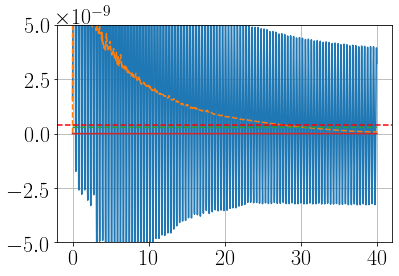

In [638]:
# CHECK BUOYANCY BUDGET OVER TOTAL DEPTH
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
dbdt = np.zeros((nt,))
adv = np.zeros((nt,))
flx = np.zeros((nt,))
dif = np.zeros((nt,))
bt = np.gradient(bm, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
for i in range(1, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z)
    
TEND = np.trapz(bt[:,0:200], axis=-1, x=z[0:200])
EBF = -Beka
BFLX = N**2*visc*(1-S2/(1+S2)) + 0*EBF

tn = time/86400
plt.plot(tn, TEND, label='TEND')
plt.plot(tn, EBF, linestyle='dashed', label='BEK')
plt.plot(tn, BFLX, linestyle='dashed', label='BEK')

#plt.plot(tn, adv)
#plt.plot(tn, flx)
plt.plot(tn, dif)
plt.axhline(np.mean(TEND[-20:-1]), color='r', linestyle='--')
plt.ylim(-0.5e-8, 0.5e-8)
plt.grid()

/data/thomas/jacob13/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


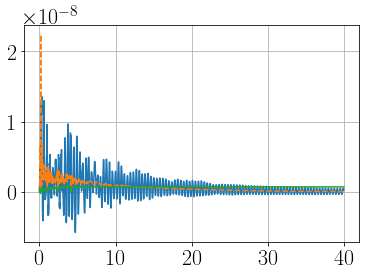

In [639]:
# CHECK BUOYANCY BUDGET
# Brink and Lentz mom balance
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
dbdt = np.zeros((nt,))
adv = np.zeros((nt,))
flx = np.zeros((nt,))
dif = np.zeros((nt,))
bt = np.gradient(bm, axis=0)/np.gradient(time[:,np.newaxis], axis=0)
for i in range(1, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z)
    indh = np.argmin(np.abs(hnum[i] - z))
    dbdt[i] = integrate.trapz(bt[i, 0:indh], x=z[0:indh])
    adv[i] = integrate.trapz(um[i,0:indh], x=z[0:indh])*N**2*tht
    flx[i] = -vbfrot[i,0,indh]+vbfrot[i,0,0]
    dif[i] = visc*(bz[i,indh]-N**2) + 1e-4*N**2
tn = time/86400
plt.plot(tn, dbdt, label='TEND')
plt.plot(tn, -Beka*hnum/Hnum, linestyle='dashed', label='BEK')
#plt.plot(tn, adv)
#plt.plot(tn, flx)
plt.plot(tn, dif)
#plt.axhline(1e-4*N**2*S2/(1+S2))
#plt.ylim(-0.5e-8, 0.5e-8)
plt.grid()

In [640]:
print(np.mean(adv[-20:-1]))
print(np.mean(dif[-20:-1]))
print(np.mean(dbdt[-20:-1]))
print(1e4*np.mean(dif[-20:-1]))

6.341340410957523e-10
6.959355946681388e-10
5.927287877163216e-11
6.959355946681388e-06


## Plot U, N2, and Q as a function of time

## U, V, N2, and Q

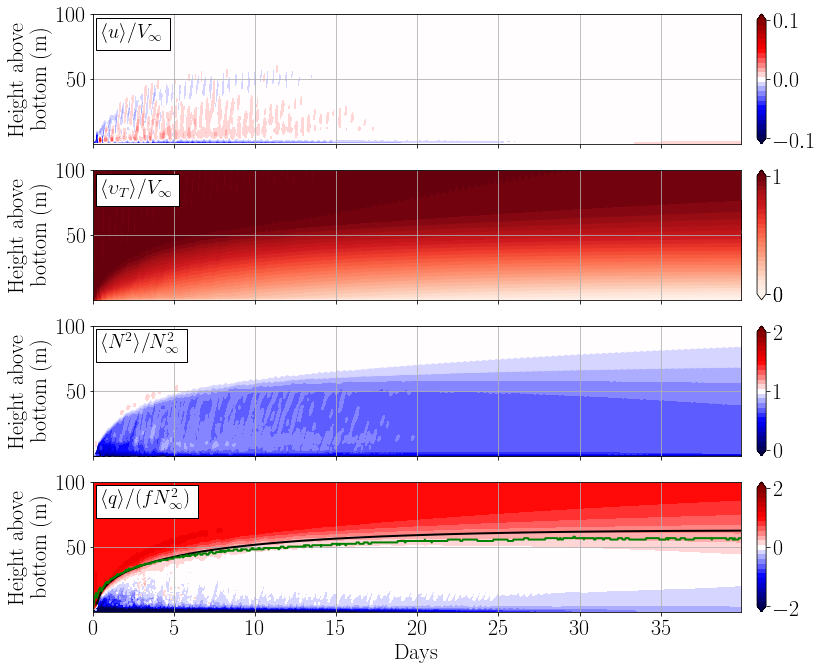

In [641]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from mpl_toolkits.axes_grid1 import make_axes_locatable

loff = 20
xoff = 0.55
asp = 13
pad = 0.02
fig, ax=plt.subplots(4,1, sharex=True, figsize=(14,11), gridspec_kw={'height_ratios': [1,1, 1, 1]})
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])

## CROSS-SLOPE VELOCITY ##
cminv = -0.1
cmaxv = -cminv
ix = ax[0].contourf(time/86400, z, np.transpose(um[:,:])/Vi,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] , aspect=asp, pad=pad)
ax[0].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(xoff,yl[-1]-loff, r'$\langle u \rangle/V_\infty$', fontsize=20, bbox=bb)
ax[0].grid()
ax[0].set_ylim(yl)

## ALONG-SLOPE VELOCITY ##
cminv = 0
cmaxv = 1
ix = ax[1].contourf(time/86400, z, np.transpose(vm[:,:]+Vi)/Vi,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='Reds', extend='both')
#ix = ax[1].contourf(time/86400, z, np.transpose(vm[:,:]+Vi)/Vi,np.linspace(cminv, cmaxv, 26), vmin=-cmaxv, vmax=cmaxv, cmap='seismic', extend='max')
plt.colorbar( ix, ax=ax[1] , ticks=[cminv,0, cmaxv] , aspect=asp, pad=pad)
ax[1].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[1].text(xoff,yl[-1]-loff, r'$\langle \upsilon_T \rangle/V_\infty$', fontsize=20, bbox=bb)
ax[1].grid()
ax[1].set_ylim(yl)
for c in ix.collections:
    c.set_edgecolor("face")

## BUOYANCY ##
cmin = 0
cmax = 2
ix = ax[2].contourf(time/86400, z, np.transpose(bz[:,:])/N**2,np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[2] , ticks=[cmin,1, cmax] , aspect=asp, pad=pad)
ax[2].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[2].set_ylim(yl)
ax[2].grid()
ax[2].text(xoff, yl[-1]-loff, r'$\langle N^2 \rangle/N^2_\infty$', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
    
## POTENTIAL VORTICITY ##

cmin = -2
cmax = 2
ix = ax[3].contourf(time/86400, z, np.transpose(qm[:,:])/(1e-4*N**2), np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[3] , ticks=[cmin, 0, cmax], aspect=asp, pad =pad)
ax[3].set_xlabel('Days')
ax[3].set_ylabel('Height above\n bottom (m)')
#ax[2].set_title('q')
ax[3].plot(time/86400, H, linewidth = 2, color='k')
ax[3].plot(time/86400, Hpv, linewidth = 2, color='g')

#ax[3].plot(time/86400, h, linewidth = 1, color='k', linestyle = '--')

ax[3].set_ylim(yl)
ax[3].text(xoff, yl[-1]-loff, r'$\langle q\rangle/(fN^2_\infty)$', fontsize=20, bbox=bb)
ax[3].grid()
for c in ix.collections:
    c.set_edgecolor("face")

SAVEFLAG = False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/Overview4Panel_{NameAppend}.pdf', bbox_inches='tight')

In [55]:
np.max(np.transpose(vm[:,:]+Vi)/Vi)

1.0190557935683637

## Cross-frontal slice plot

Make figure showing the SI overturning cells and buoyancy field.

1.0055123230161565


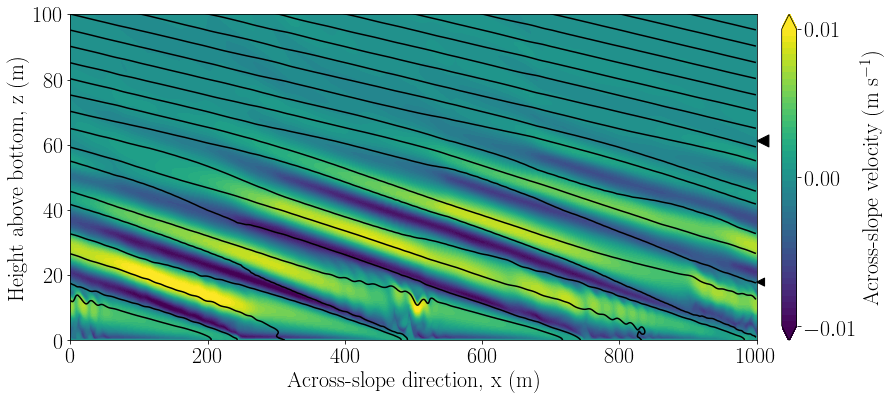

In [648]:
ti = -1;
ti = np.where(time/86400>12)[0][0]
cmin = -0.01
cmax = -cmin
cmap = 'viridis'

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 6), gridspec_kw = {'width_ratios':[4]})
ix = ax.contourf(x, zm-zm[0], np.transpose(u[ti,:,:]), np.linspace(cmin, cmax, 50), vmin = cmin, vmax =cmax,cmap = cmap, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
#cbaxes = inset_axes(ax, width="30%", height="6%", loc=1, borderpad=0.5, axes_kwargs={'facecolor':'lightgrey'}) 

#cb = plt.colorbar(ix, cax=cbaxes, orientation='horizontal', ticks=[cmin, cmax])
cb = plt.colorbar(ix, ticks=[cmin, 0, cmax], pad=0.03)

cb.set_label('Across-slope velocity (m s$^{-1}$)',  color='k')
#cbaxes.tick_params(labelcolor='w', labelsize=18)
cb.solids.set_edgecolor("face")

ax.contour(x, zm-zm[0], np.transpose(bf[ti,:,:]), 50, colors='k')

ax.set_xlabel('Across-slope direction, x (m)')
ax.set_ylim((0, 100))
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_ylabel('Height above bottom, z (m)')

Hnum, hnum = findH(qm[ti,:], 1e-4*N**2, vbfrot[ti,0,:] , z)
Hnum, hnum = findH(qm[ti,:], 1e-4*N**2, vbfh[ti,:] , z)
to = 1
hap = findHScale(Hnum, np.sqrt(np.mean(-tauy[ti-to:ti+to])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti-to:ti+to]), np.mean(vbfrot[ti-to:ti+to,0,:], axis=0), z, S2)
#hap = findHScale(H[ti], np.sqrt(-tauy[ti]/1030), N**2*tht/(1e-4*(1+S2)), Beka[ti], vbfrot[ti,0,:], z, S2)
#hap = findHScale(Hnum, np.sqrt(-tauy[ti]/1030), N**2*tht/(1e-4*(1+S2)), Beka[ti], vbfrot[ti,0,:], z, S2)

to = 1
#Hnum, hnum = findH(np.mean(qm[ti-to:ti+to,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti-to:ti+to,:], axis=0) , z)

#ax.plot(1000, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(1000, H[ti], marker='<', color='w', markeredgecolor='k', markersize=20)
#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.annotate('', xy=(1000, Hnum), xytext=(1010, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('', xy=(1000, hnum), xytext=(1010, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#ax.axhline(hap, color='r')
ax.set_xlim(0, 1000)
SAVEFLAG = False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/Slice_{NameAppend}.pdf', bbox_inches='tight')

In [ ]:
Hnum, hnum = findH(qm[ti,:], 1e-4*N**2, vbfh[ti,:] , z)
hap = findHScale(Hnum, np.sqrt(np.mean(-tauy[ti-to:ti+to])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti-to:ti+to]), np.mean(vbfrot[ti-to:ti+to,0,:], axis=0), z, S2)

plt.plot(np.mean(vbfrot[ti-to:ti+to, 0, :], axis=0)/np.mean(-Beka[ti]), z)
plt.plot(vbfh[ti,:]/np.mean(-Beka[ti]), z)

plt.axhline(Hnum)
plt.axhline(hnum)
plt.axhline(hap)
plt.ylim(0, Hnum+10)

In [ ]:
# PLOT IN TERMS OF STREAMFUNCTION
ti = -1;
ti = np.where(time/86400>12)[0][0]
ti = np.where((time/86400>8.5) & (time/86400<9.5))[0] # Pick the time range to average over
cmin = -0.01
cmax = -cmin
cmap = 'viridis'


psi = integrate.cumtrapz(np.mean(u[ti,:,:], axis=0), x=z, axis=-1, initial=0)

cmin = -np.max(np.abs(psi))
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 6), gridspec_kw = {'width_ratios':[4]})
ix = ax.contour(x, zm-zm[0], np.transpose(psi[:,:]), np.linspace(cmin, cmax, 20), vmin = cmin, vmax =cmax,cmap = cmap, extend='both')
#for c in ix.collections:
  #  c.set_edgecolor('face')
#cbaxes = inset_axes(ax, width="30%", height="6%", loc=1, borderpad=0.5, axes_kwargs={'facecolor':'lightgrey'}) 

#cb = plt.colorbar(ix, cax=cbaxes, orientation='horizontal', ticks=[cmin, cmax])
cb = plt.colorbar(ix, ticks=[cmin, 0, cmax], pad=0.03)

cb.set_label('Stream function (m$^2$ s$^{-1}$)',  color='k')
#cbaxes.tick_params(labelcolor='w', labelsize=18)
#cb.solids.set_edgecolor("face")

ax.contour(x, zm-zm[0], np.transpose(np.mean(bf[ti,:,:], axis=0)), 50, colors='k')

ax.set_xlabel('Across-slope direction, x (m)')
ax.set_ylim((0, 100))
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_ylabel('Height above bottom, z (m)')

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)
ax.plot(1000, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(0, 1000)

if SAVEFLAG:
    plt.savefig(f'./MSFigs/Slice_{NameAppend}.pdf', bbox_inches='tight')

In [ ]:
nt = H.size
hn = np.zeros((nt,))
Hnum = np.zeros((nt,))
for ti in range(0, nt):
    Hnum[ti], hnum = findH(qm[ti,:], 1e-4*N**2, vbfh[ti,:] , z)
    hn[ti] = findHScale(Hnum[ti], np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti]), vbfrot[ti,0,:], z, S2)

##plt.plot(np.mean(vbfr[ti-8:ti+8,0,:], axis=0)/(-Beka[ti]), z)
#plt.axhline(Hnum)

plt.figure()
#plt.plot(ent)
#plt.plot(Beka)
plt.plot(time/86400, hn)
plt.plot(time/86400, Hnum)

plt.ylim(0, 100)

In [ ]:
# PLOT M Surfaces
ti = -1;
ti = np.where(time/86400>12)[0][0]
ti = np.where((time/86400>11.5) & (time/86400<12.5))[0] # Pick the time range to average over
cmin = -0.01
cmax = -cmin
cmap = 'viridis'


M = np.mean(v[ti,:,:]+Vi, axis=0) + 1e-4*x[:, np.newaxis]
#M = np.mean(v[ti,:,:]+Vi, axis=0) + (1e-4-np.gradient(np.mean(v[ti,:,:], axis=0), axis=0)/np.gradient(x[:,np.newaxis], axis=0))*x[:, np.newaxis]

cmin = -np.max(np.abs(M))
cmin = 0
cmax = np.max(np.abs(M))
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 6), gridspec_kw = {'width_ratios':[4]})
ix = ax.contour(x, zm-zm[0], np.transpose(M[:,:]), np.linspace(cmin, cmax, 20), vmin = cmin, vmax =cmax,cmap = cmap, extend='both')
#for c in ix.collections:
  #  c.set_edgecolor('face')
#cbaxes = inset_axes(ax, width="30%", height="6%", loc=1, borderpad=0.5, axes_kwargs={'facecolor':'lightgrey'}) 

#cb = plt.colorbar(ix, cax=cbaxes, orientation='horizontal', ticks=[cmin, cmax])
cb = plt.colorbar(ix, ticks=[cmin, 0, cmax], pad=0.03)

cb.set_label('Stream function (m$^2$ s$^{-1}$)',  color='k')
#cbaxes.tick_params(labelcolor='w', labelsize=18)
#cb.solids.set_edgecolor("face")

ax.contour(x, zm-zm[0], np.transpose(np.mean(bf[ti,:,:], axis=0)), 50, colors='k')

ax.set_xlabel('Across-slope direction, x (m)')
ax.set_ylim((0, 100))
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_ylabel('Height above bottom, z (m)')

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)
ax.plot(1000, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(0, 1000)

if SAVEFLAG:
    plt.savefig(f'./MSFigs/Slice_{NameAppend}.pdf', bbox_inches='tight')

0.8121576866762236


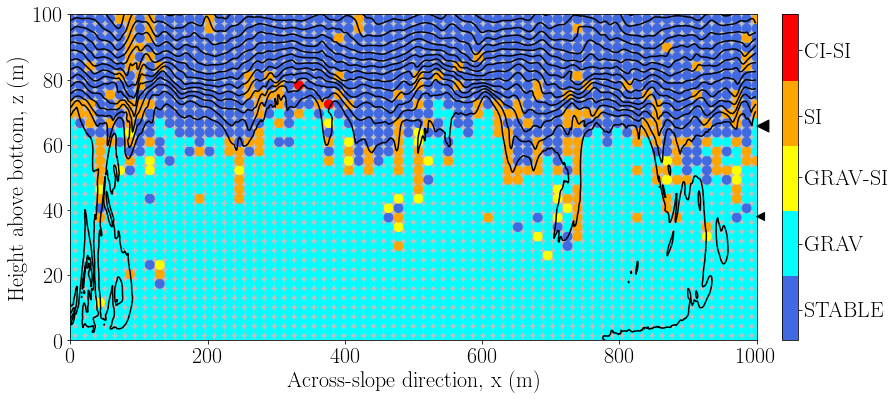

In [105]:
# Plot of instability regions SMOOTHED

import scipy as sp
import scipy.ndimage

# PICK TIMERANGE
ti1 = np.where(time/86400>12)[0][0]
ti = np.where((time/86400>11.95) & (time/86400<12.05))[0] # Pick the time range to average over
ti = np.where(time/86400>12)[0][0:8] # Averaging over a 2 hour period

# LOAD VARIABLES
qo = np.mean(q[ti,:,:], axis=0)
bo = np.mean(bf[ti,:,:], axis=0) # This includes N^2_\infty
vo = np.mean(v[ti,:,:], axis=0)
uo = np.mean(u[ti,:,:], axis=0)
wo = np.mean(w[ti,:,:], axis=0)
xo = x
zo = z

# CALCULATE GRADIENTS IN NON-ROTATED COORDINATES
vxhat = np.gradient(vo, axis=0)/np.gradient(xo[:,np.newaxis], axis=0)*np.cos(tht) \
    - np.gradient(vo, axis=1)/np.gradient(zo)*np.sin(tht)
#vzhat = np.gradient(vo, axis=1)/np.gradient(zo, axis=0)*np.cos(tht) \
#    + np.gradient(vo, axis=0)/np.gradient(xo[:,np.newaxis], axis=0)*np.sin(tht)
bzhat = (np.gradient(bo, axis=-1)/np.gradient(zo))*np.cos(tht) \
    + np.gradient(bo, axis=0)/np.gradient(xo[:,np.newaxis], axis=0)*np.sin(tht)
bxhat = (np.gradient(bo, axis=0)/np.gradient(xo[:,np.newaxis], axis=0))*np.cos(tht) \
    - np.gradient(bo, axis=1)/np.gradient(zo)*np.sin(tht)
vgz = bxhat/1e-4
vg = integrate.cumtrapz(vgz, x=zo, axis=-1, initial=0)
vg = vg-vg[:,-1][:,np.newaxis]
vgx = (np.gradient(vg, axis=0)/np.gradient(xo[:,np.newaxis], axis=0))*np.cos(tht) \
    - np.gradient(vg, axis=1)/np.gradient(zo)*np.sin(tht)
bxxhat = (np.gradient(bxhat, axis=0)/np.gradient(xo[:,np.newaxis], axis=0))*np.cos(tht) \
    - np.gradient(bxhat, axis=1)/np.gradient(zo)*np.sin(tht)
#vgx = integrate.cumtrapz(bxxhat/1e-4, x=zo, axis=-1, initial=0)
vgxm = np.mean(vgx, axis=0)[np.newaxis,:]
vgxm = np.tile(vgxm, (1024, 1))
vort = (1e-4+vxhat)*bzhat 
#baro = -bxhat*vzhat
#qo = vort + baro

# FLOW IS STABLE IF PV is POSITIVE
#STABLE = qo>0
#GRAV = np.logical_and(bzhat < 0, bzhat<0)
#CI = np.logical_and(bzhat>0, vort<0)

#rib = bzhat/(vzhat**2)
#rib = 1e-8*bzhat/bxhat**2 #Balanced Richardson number
#phib = np.arctan2(-1,rib)*180/np.pi # See Thomas et al. 2013 equation 8 (note that tan = y/x)
#phic = np.arctan2(-(1e-4+vgxm),1e-4)*180/np.pi #See Thomas et al 2013 equation 9

#F2 = 1e-4*(1e-4+vgxm)
#alpha = 1/2*np.arctan2(2*bxhat,(bzhat-F2))
#BFLUXGSP = - (bxhat - bzhat*np.tan(alpha))/(F2 - bxhat*np.tan(alpha))*(1e-8/bxhat) #See Thomas et al. 2013 equation 41

# Interpolate to coarser grid (otherwise very noisy)
xd = np.linspace(0, 1000, 70)
zd = np.linspace(0,200, 70 )
#f = interpolate.interp2d(x, z, np.transpose(phib), kind='cubic')
#phib = np.transpose(f(xd, zd))
#f = interpolate.interp2d(x,z, np.transpose(phic), kind='cubic')
#f = interpolate.interp2d(x,z, np.transpose(phic), kind='cubic')
#phic = np.transpose(f(xd, zd))
#f = interpolate.interp2d(x, z, np.transpose(BFLUXGSP), kind='cubic')
#BFLUXGSP = np.transpose(f(xd, zd))

# Interpolate other variables first
xd = np.linspace(0, 1000, 70)
zd = np.linspace(0,200, 70 )
f = interpolate.interp2d(x, z, np.transpose(bzhat), kind='cubic')
bzhat = np.transpose(f(xd,zd))
f = interpolate.interp2d(x, z, np.transpose(bxhat), kind='cubic')
bxhat = np.transpose(f(xd,zd))
rib = 1e-8*bzhat/bxhat**2 #Balanced Richardson number
phib = np.arctan2(-1,rib)*180/np.pi # See Thomas et al. 2013 equation 8 (note that tan = y/x)
f = interpolate.interp2d(x,z, np.transpose(vgx), kind='cubic')
vgx = np.transpose(f(xd,zd))
f = interpolate.interp2d(x,z, np.transpose(vgxm), kind='cubic')
vgxm = np.transpose(f(xd,zd))
F2 = 1e-4*(1e-4+vgxm)
alpha = 1/2*np.arctan2(2*bxhat,(bzhat-F2))
BFLUXGSP = - (bxhat - bzhat*np.tan(alpha))/(F2 - bxhat*np.tan(alpha))*(1e-8/bxhat) #See Thomas et al. 2013 equation 41
phic = np.arctan2(-(1e-4+vgxm),1e-4)*180/np.pi

# Flow is stable when phib is greater than the critical threshold (PV>0)
STABLE = phib>phic
# Flow is gravitationally or SI unstable when phib<90 degrees (N^2<0)
GRAVSI = phib<-90
# Flow is only dominated by buoyancy prod when BFLUXGSP>1 is VBP>GSP.
GRAV = BFLUXGSP>1
# CI is for unstable cases where phib>-45
CI = np.logical_and(phib<phic, phib>-45)


# Assign colorscale (order here matters for plotting purposes)
TOT = 20 + 0*GRAV#STABLE

TOT[np.logical_and(~CI, ~STABLE)] = 140#SI
TOT[np.logical_and(CI, ~STABLE)] = 180#CI
TOT[GRAVSI] = 100
TOT[GRAV] = 60
# Make a colormap
cmap = plt.cm.get_cmap('gist_rainbow', 4)
cmap = mpl.colors.ListedColormap(['royalblue', 'cyan',
                                  'yellow', 'orange', 'red'])
cmap.set_under('blue')
bounds = [0, 40, 80, 120, 160, 200]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Do the plotting
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 6), gridspec_kw = {'width_ratios':[4]})
X, Z = np.meshgrid(xd, zd)
ix = ax.scatter(X.ravel(), Z.ravel(), c=np.transpose(TOT).ravel(), cmap=cmap, marker='o', s=80)
cb = plt.colorbar(ix, pad=0.03)
cb.set_ticks([35, 67.5, 100, 130, 162.5])
cb.ax.set_yticklabels(['STABLE', 'GRAV','GRAV-SI', 'SI', 'CI-SI'])
cb.solids.set_edgecolor("face")

#ax.contour(x, zm-zm[0], np.transpose(bf[ti1,:,:]), 50, colors='k')
ax.contour(xo, zo, np.transpose(bo), 50, colors='k')
ax.set_xlabel('Across-slope direction, x (m)')
ax.set_ylim((0, 100))
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_ylabel('Height above bottom, z (m)')
ax.set_xlim(0, 1000)
#Hnum, hnum = findH(np.mean(qo[:,:], axis=(0)), 1e-4*N**2, np.mean(wo[:,:]*(bo[:,:]-np.mean(bo, axis=0)), axis=0) , z)

#ax.plot(0, Hnum, marker='d', markersize=10, color='w')
#ax.plot(0, hnum, marker='d', markersize=10, color='w')
#ax.plot(x, Hnum, 'w')
#ax.plot(x, hnum, 'w')
ax.set_facecolor('0.75')

Hnum, hnum = findH(np.mean(qm[ti,:],axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)
Hnum, hnum = findH(qm[ti[0],:], 1e-4*N**2, vbfh[ti[0],:] , z)
hap = findHScale(np.mean(H[ti]), np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti]), np.mean(vbfrot[ti,0,:], axis=0), z, S2)

#ax.plot(1000, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.annotate('', xy=(1000, Hnum), xytext=(1010, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('', xy=(1000, hnum), xytext=(1010, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
ax.set_xlim(0, 1000)
#print(np.mean(H[ti]))
SAVEFLAG = True
if SAVEFLAG:
    plt.savefig(f'./MSFigs/SliceStability_{NameAppend}.pdf', bbox_inches='tight')

In [ ]:
ti = np.where(time/86400>12)[0][0:8]-3
Hnum, hnum = findH(np.mean(qm[ti,:],axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0) , z)

plt.plot(np.mean(vbfh[ti,:], axis=0), z)
#plt.plot(np.mean(-bz[ti,:], axis=0)*1e-4, z)
plt.ylim(0, Hnum+10)
plt.axhline(hnum, color='r')
plt.axhline(Hnum/2, linestyle='--')
plt.grid()

zero_crossings = np.where(np.diff(np.signbit(np.mean(vbfh[ti,:], axis=0))))[0]
plt.plot(0*z[zero_crossings], z[zero_crossings], marker='x')

inds = np.where(np.logical_and(np.diff(np.signbit(np.mean(vbfh[ti,:], axis=0))), 0.5*(z[1:]+z[0:-1])<Hnum*0.5))[0]
if inds.size == 0:
        inds = np.where(np.logical_and(np.diff(np.signbit(np.mean(vbfh[ti,:], axis=0))), 0.5*(z[1:]+z[0:-1])<Hnum))[0]
plt.plot(0*z[inds], z[inds], marker='d')


## MOMENTUM BUDGET

1.0719031810448074


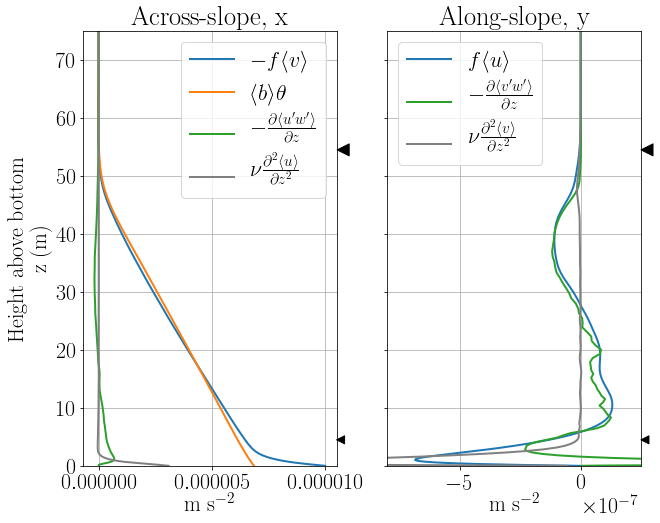

In [172]:
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>11) & (time/86400<13))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0) , z)

fig, ax = plt.subplots(1,2,figsize=(10,8),sharey=True)
TEND = (um[ti[-1], :] - um[ti[0],:])/(time[ti[-1]] - time[ti[0]])
COR = -1e-4*np.mean(vm[ti,:], axis=0)
BUOY = np.mean(bm[ti,:], axis=0)*tht
uz = np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
uzz = np.gradient(uz)/np.gradient(z)
VISC = 0*1e-4*uzz-np.gradient(np.mean(upwp[ti,0,:], axis=0))/np.gradient(z)
ax[0].plot(COR, z,linewidth=2, label=r'$-f\langle v \rangle$')
ax[0].plot(BUOY, z,linewidth=2, label=r'$\langle b \rangle \theta$')
ax[0].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle u^\prime w^\prime\rangle}{\partial z} $')
ax[0].plot(1e-4*uzz, z,linewidth=2, label=r'$\nu \frac{\partial ^2 \langle u \rangle}{\partial z^2}$', color='0.5')

#plt.plot(TEND, z)
#ax[0].plot(-COR + BUOY+VISC, z, linestyle = '--', label='SUM')
ax[0].set_ylim(0, 75)
ax[0].set_ylabel('Height above bottom\n z (m)')
ax[0].legend()
ax[0].grid()
ax[0].set_title('Across-slope, x')
ax[0].set_xlabel('m s$^{-2}$')
xlims = ax[0].get_xlim()
hap = findHScale(np.mean(H[ti]), np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti]), np.mean(vbfrot[ti,0,:], axis=0), z, S2)
#ax[0].plot(xlims[-1], np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)
#ax[0].plot(xlims[-1], hap, marker='<', color='w', markeredgecolor='k', markersize=15)

#ax[0].plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[0].plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax[0].set_xlim(xlims)
ax[0].annotate('', xy=(xlims[-1], Hnum), xytext=(xlims[-1]*1.05, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[0].annotate('', xy=(xlims[-1], hnum), xytext=(xlims[-1]*1.015, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#Along-slope
TEND = (vm[ti[-1], :] - vm[ti[0],:])/(time[ti[-1]] - time[ti[0]])

COR = 1e-4*np.mean(um[ti,:], axis=0)
vz = np.gradient(np.mean(vm[ti,:], axis=0))/np.gradient(z)
vzz = np.gradient(vz)/np.gradient(z)
VISC = 0*1e-4*vzz-np.gradient(np.mean(vpwp[ti,:], axis=0))/np.gradient(z)
ax[1].plot(COR, z, label=r'$f\langle u \rangle$', linewidth=2)
plt.plot(0, 0) # keep same coloring between subplots
ax[1].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle v^\prime w^\prime\rangle}{\partial z} $')
ax[1].plot(1e-4*vzz, z,linewidth=2, label=r'$\nu \frac{\partial ^2 \langle v \rangle}{\partial z^2}$', color='0.5')

#ax[1].plot(-COR +VISC, z, linestyle = '--', label='SUM')
ax[1].set_ylim(0, 75)
ax[1].set_xlim(-8e-7, 0.25e-6)
ax[1].legend()
ax[1].grid()
ax[1].set_title('Along-slope, y')
ax[1].set_xlabel('m s$^{-2}$')

#ax[1].plot(2.5e-7, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax[1].plot(2.5e-7, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
#ax[1].plot(2.5e-7, np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)
#ax[1].plot(2.5e-7, hap, marker='<', color='w', markeredgecolor='k', markersize=15)
ax[1].annotate('', xy=(2.5e-7, Hnum), xytext=(2.55e-7, Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[1].annotate('', xy=(2.5e-7, hnum), xytext=(2.55e-7, hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#ax[1].set_xlim(-8e-7, 2e-7)
SAVEFLAG = False
if SAVEFLAG:
    plt.savefig(f'./MSFigs/MomBudget_{NameAppend}.pdf', bbox_inches='tight')

In [ ]:
np.mean(H[ti])

In [ ]:
# Look at <v'w'> compared to nu dvdz

# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>9) & (time/86400<11))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

fig, ax = plt.subplots(1,2,figsize=(10,8),sharey=True)
TEND = (um[ti[-1], :] - um[ti[0],:])/(time[ti[-1]] - time[ti[0]])
COR = -1e-4*np.mean(vm[ti,:], axis=0)
BUOY = np.mean(bm[ti,:], axis=0)*tht
uz = np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
uzz = np.gradient(uz)/np.gradient(z)
VISC = 0*1e-4*uzz-np.gradient(np.mean(upwp[ti,0,:], axis=0))/np.gradient(z)
ax[0].plot(COR, z,linewidth=2, label=r'$-f\langle v \rangle$')
ax[0].plot(BUOY, z,linewidth=2, label=r'$\langle b \rangle \theta$')
ax[0].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle u^\prime w^\prime\rangle}{\partial z} $')
ax[0].plot(1e-4*uzz, z,linewidth=2, label=r'$\nu \frac{\partial ^2 \langle u \rangle}{\partial z^2}$', color='0.5')

#plt.plot(TEND, z)
#ax[0].plot(-COR + BUOY+VISC, z, linestyle = '--', label='SUM')
ax[0].set_ylim(0, 75)
ax[0].set_ylabel('Height above bottom\n z (m)')
ax[0].legend()
ax[0].grid()
ax[0].set_title('Across-slope, x')
ax[0].set_xlabel('m s$^{-2}$')
xlims = ax[0].get_xlim()
ax[0].plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
ax[0].plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax[0].set_xlim(xlims)
#Along-slope
TEND = (vm[ti[-1], :] - vm[ti[0],:])/(time[ti[-1]] - time[ti[0]])

COR = 1e-4*np.mean(um[ti,:], axis=0)
vz = np.gradient(np.mean(vm[ti,:], axis=0))/np.gradient(z)
vzz = np.gradient(vz)/np.gradient(z)
VISC = 0*1e-4*vzz-np.mean(vpwp[ti,:], axis=0)
ax[1].plot(COR, z, label=r'$f\langle u \rangle$', linewidth=2)
plt.plot(0, 0) # keep same coloring between subplots
ax[1].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle v^\prime w^\prime\rangle}{\partial z} $')
ax[1].plot(1e-4*vz, z,linewidth=2, label=r'$\nu \frac{\partial ^2 \langle v \rangle}{\partial z^2}$', color='0.5')

#ax[1].plot(-COR +VISC, z, linestyle = '--', label='SUM')
ax[1].set_ylim(0, 75)
#ax[1].set_xlim(-8e-7, 0.25e-6)
ax[1].legend()
ax[1].grid()
ax[1].set_title('Along-slope, y')
ax[1].set_xlabel('m s$^{-2}$')
ax[1].plot(2.5e-7, hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
ax[1].plot(2.5e-7, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
#ax[1].plot(2.5e-7, np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)

#ax[1].set_xlim(-8e-7, 2e-7)
if SAVEFLAG:
    plt.savefig(f'./MSFigs/MomBudget_{NameAppend}.pdf', bbox_inches='tight')

In [ ]:
# ZOOM IN ON AGEOSTROPHIC ACROSS-SLOPE BUDGET
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>11) & (time/86400<13))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

fig, ax = plt.subplots(1,3,figsize=(10,8),sharey=True)
TEND = (um[ti[-1], :] - um[ti[0],:])/(time[ti[-1]] - time[ti[0]])
BUOY = np.mean(bm[ti,:], axis=0)*tht
COR = -1e-4*np.mean(vm[ti,:], axis=0) - BUOY

uz = np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
uzz = np.gradient(uz)/np.gradient(z)
VISC = 0*1e-4*uzz-np.gradient(np.mean(upwp[ti,0,:], axis=0))/np.gradient(z)

ax[0].plot(COR, z)
ax[0].plot(VISC, z)

ax[1].plot(integrate.cumtrapz(COR, x=z, initial=0), z)
ax[1].plot(-np.mean(upwp[ti,0,:], axis=0), z)
ax[1].plot(np.mean(-taux[ti]/1030), 0, marker='x')
ax[1].plot(1e-4*uz, z)
ax[1].axhline(hnum)
ax[1].axhline(Hnum)
ax[2].plot(np.gradient(COR)/np.gradient(z), z)
ax[2].plot(np.gradient(VISC)/np.gradient(z), z)

ax[2].set_xlim(-1e-7, 1e-7)

ax[0].set_ylim(0, 60)

ax[0].grid()
ax[1].grid()
ax[2].grid()

In [ ]:
ti = np.where((time/86400>11) & (time/86400<13))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

BACKGROUND = 1e-4*N**2
PERTB = 1e-4*np.gradient(np.mean(bm[ti,:],axis=0))/np.gradient(z)
SH = -N**2*tht*np.gradient(np.mean(vm[ti,:], axis=0))/np.gradient(z)
plt.plot(np.mean(qm[ti,:], axis=0), z)
plt.axvline(BACKGROUND)
plt.plot(PERTB, z)
plt.plot(SH, z)
plt.plot(BACKGROUND+PERTB+SH, z)
plt.ylim(0, 50)
plt.axhline(hnum)
plt.grid()
plt.xlim(-1e-9, 1e-9)

In [ ]:
ti = np.where((time/86400>12) & (time/86400<14))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)
SP = -np.mean(upwp[ti,0,:], axis=0)*np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
VBP = np.mean(vbfrot[ti,0,:], axis=0)
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,10))


TEND = (um[ti[-1], :] - um[ti[0],:])/(time[ti[-1]] - time[ti[0]])
BUOY = np.mean(bm[ti,:], axis=0)*tht
COR = -1e-4*np.mean(vm[ti,:], axis=0) - BUOY

uz = np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
uzz = np.gradient(uz)/np.gradient(z)
VISC = 0*1e-4*uzz-np.gradient(np.mean(upwp[ti,0,:], axis=0))/np.gradient(z)

ax[0].plot(COR, z, label='$-fv_a$')
ax[0].plot(VISC, z, label=r'$-\langle u^\prime w^\prime\rangle_z$')
ax[0].legend()
ax[0].grid()
ax[0].axhline(hnum)

ax[1].plot(-np.mean(upwp[ti,0,:], axis=0), z, label=r'$-\langle u^\prime w^\prime\rangle$')
ax[1].plot(np.mean(-taux[ti]/1030), 0, marker='x')
ax[1].plot(1e-4*uz, z)
ax[1].axhline(hnum)
ax[1].legend()

ax[1].grid()

ax[2].plot(SP, z, label = r'$-\langle u^\prime w^\prime \rangle \langle u \rangle_z$')
ax[2].plot(VBP, z, label='$VBP$')
ax[2].plot(SP+VBP, z, label='sum')
ax[2].axhline(hnum)
ax[2].set_ylim(0, 60)
ax[2].legend()
ax[2].grid()

## Buoyancy Budget

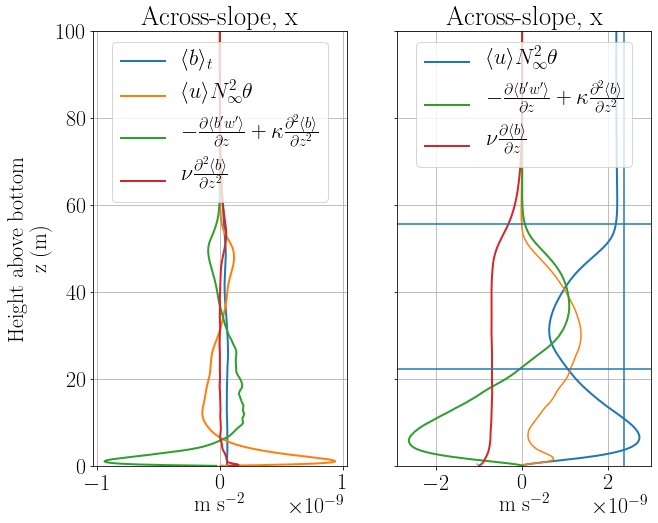

In [222]:
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>20) & (time/86400<23))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)
fig, ax = plt.subplots(1,2,figsize=(10,8),sharey=True)
TEND = (bm[ti[-1], :] - bm[ti[0],:])/(time[ti[-1]] - time[ti[0]])
ADV= -np.mean(um[ti,:], axis=0)*N**2*tht
bza = np.mean(bz[ti,:], axis=0)
bzz = np.gradient(bza)/np.gradient(z)
VISC = 0*1e-4*bzz-np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)
ax[0].plot(TEND, z,linewidth=2, label=r'$\langle b \rangle_t$')
ax[0].plot(ADV, z,linewidth=2, label=r'$\langle u \rangle N^2_\infty\theta$')
ax[0].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle b^\prime w^\prime\rangle}{\partial z} +\kappa \frac{\partial ^2 \langle b \rangle}{\partial z^2}$')
ax[0].plot(1e-4*bzz, z,linewidth=2, label=r'$\nu \frac{\partial ^2 \langle b \rangle}{\partial z^2}$')
#plt.plot(TEND, z)
#ax[0].plot(-COR + BUOY+VISC, z, linestyle = '--', label='SUM')
ax[0].set_ylim(0, 100)
#ax[0].set_xlim(-1e-9, 1e-9)
ax[0].set_ylabel('Height above bottom\n z (m)')
ax[0].legend(loc='upper center')
ax[0].grid()
ax[0].set_title('Across-slope, x')
ax[0].set_xlabel('m s$^{-2}$')

# CUMULATIVE INTEGRAL
ADV= -integrate.cumtrapz(np.mean(um[ti,:], axis=0)*N**2*tht, x=z, initial=0)
bza = np.mean(bz[ti,:]-N**2, axis=0)
VISC = 0*1e-4*bza-np.mean(vbfrot[ti,0,:], axis=0)
#ax[0].plot(TEND, z,linewidth=2, label=r'$\langle b \rangle_t$')
ax[1].plot(ADV, z,linewidth=2, label=r'$\langle u \rangle N^2_\infty\theta$')
ax[1].plot(-N**2*tht*np.mean(vpwp[ti,:], axis=0)/(1e-4*(1+S2)), z)
ax[1].plot(VISC, z,linewidth=2, label=r'$-\frac{\partial \langle b^\prime w^\prime\rangle}{\partial z} +\kappa \frac{\partial ^2 \langle b \rangle}{\partial z^2}$')
ax[1].plot(1e-4*bza, z,linewidth=2, label=r'$\nu \frac{\partial \langle b \rangle}{\partial z}$')
ax[1].plot(-1e-4*N**2, 0, marker='x')
#ax[0].plot(-COR + BUOY+VISC, z, linestyle = '--', label='SUM')
ax[1].set_ylim(0, 100)
ax[1].axhline(Hnum)
ax[1].axhline(hnum)
ax[1].axvline(-np.mean(Beka[ti]))
#ax[1].set_xlim(-1e-9, 1e-9)
#ax[1].set_ylabel('Height above bottom\n z (m)')
ax[1].grid()
ax[1].set_title('Across-slope, x')
ax[1].set_xlabel('m s$^{-2}$')
ax[1].legend(loc='upper center')

In [ ]:
# CUMULATIVE
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>20) & (time/86400<24))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)

ADV= -integrate.cumtrapz(np.mean(um[ti,:], axis=0), x=z, initial=0) 
vz = np.gradient(np.mean(vm[ti,:], axis=0))/np.gradient(z)
vzz = np.gradient(vz)/np.gradient(z)
FLUX = np.mean(-vpwp[ti,:]+1e-4*vz + 1*tauy[ti,np.newaxis]/1030, axis=0)/(1e-4*(1+S2))
FLUX = -FLUX
plt.plot(ADV, z)
plt.plot(FLUX, z)
plt.plot(-1e-4*vz/(1e-4*(1+S2)), z)
plt.ylim(0, 200)
plt.axvline(np.mean(tauy[ti])/(1035*1e-4*(1+S2)))
plt.plot(-np.mean(tauy[ti])/(1035*1e-4*(1+S2))*(z/Hnum), z)

#plt.xlim(-0.03, 0.002)
plt.ylim(0, 100)
plt.axhline(hnum)
plt.grid()

In [ ]:
# STRATIFICATION BUDGET
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>21) & (time/86400<23))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)
TEND = (bz[ti[-1], :] - bz[ti[0],:])/(time[ti[-1]] - time[ti[0]])

uz = np.gradient(np.mean(um[ti,:], axis=0))/np.gradient(z)
uzz = np.gradient(uz)/np.gradient(z)
uzzz = np.gradient(uzz)/np.gradient(z)
ADV= -uz*N**2*tht
VISC = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)
VISC = np.gradient(VISC)/np.gradient(z)

plt.plot(TEND, z)
plt.plot(ADV, z)
plt.plot(VISC, z)
plt.ylim(0, 50)
plt.xlim(-0.2e-9, 0.2e-9)
plt.axhline(hnum)
plt.grid()

In [ ]:
plt.plot(np.mean(bz[ti,:], axis=0), z)
#plt.plot(np.mean(bzr[ti,:], axis=0), z)
plt.axhline(np.mean(h[ti]))

In [ ]:
plt.semilogx(np.mean(us[ti])**3/(z)*(0.5+z/np.mean(Lo[ti])*(1-z/np.mean(H[ti]))), z)
plt.axhline(np.mean(h[ti]))
plt.axhline(np.mean(H[ti]))
plt.plot(np.mean(-diss[ti,0,:], axis=0), z)
plt.axvline(np.mean(0-Beka[ti]))
plt.plot(np.mean(-Beka[ti])*(1-z/np.mean(H[ti])), z)
plt.ylim(0, 50)

In [ ]:
np.mean(Lo[ti])

## PSEUDO-GSP and BUOYANCY FLUX


In [ ]:
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>11) & (time/86400<13))[0] # Pick the time range to average over
#ti = np.where((time/86400>6) & (time/86400<8))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)

fig, ax = plt.subplots(1,1,figsize=(5,8),sharey=True)

GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
#VBF = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)

ax.plot(GSP, z, label=r'$-\frac{N^2_\infty \theta}{f}\langle v^\prime w^\prime \rangle$', linewidth=2)
ax.plot(VBF, z, label=r'$\langle w^\prime b^\prime \rangle$', linewidth=2)
ax.plot(GSP+VBF, z, label='SUM', linewidth=2)
#ax.plot(np.mean(wq[ti,0,:], axis=0)*1e4, z)
ax.axvline(-np.mean((1+S2)*Beka[ti]), linestyle='--', color='k')
#ax.axhline(np.mean(H[ti]))
ax.set_ylim(0, 75)
ax.set_ylabel('Height above bottom\n z (m)')
ax.legend()
ax.grid()
ax.set_xlabel('m$^2$ s$^{-3}$')
xlims = ax.get_xlim()
ax.plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
ax.plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)

#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(xlims)
if SAVEFLAG:
    plt.savefig(f'./MSFigs/GSPFLUX_{NameAppend}.pdf', bbox_inches='tight')

In [ ]:
##plt.plot(time/86400, np.min(vbfrot, axis=-1))
#plt.plot(time/86400, np.max(vbfrot, axis=-1))
plt.plot(time/86400, -np.min(vbfrot, axis=-1)/np.max(vbfrot, axis=-1))
plt.ylim(-1, 1)

plt.plot(time/86400, hall/Hall)

## ENERGY BUDGET

In [ ]:
f = h5py.File(filename, 'r')

SP = f['tasks']['SP']
SP.shape

In [ ]:
#EKE Fancy 2 panel


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# Bekfull = -Bek[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )/(1+N**2*np.tan(tht[0,0,0])**2/1e-8)
# Bekfull[Bekfull> 0 ] = 0
# Bekfull[np.isnan(Bekfull)] = 0

    
# bdrag = (vm[:,0])*tauy/(1030)
# damp = -0.005*((-20 - (z-z[-1]))/20)**2
# damp[(z[:]-z[-1])<-20] = 0

# damp = np.mean(damp*up*up + damp*vp*vp + damp*w[:,:,:]**2, axis=1)

startind=48*0
zl = np.where((z>0) & (z<=z[-1]))[0]
bdrag = -1e-4*(EKE[:,0,1] - EKE[:,0,0])/(z[1]-z[0])
# plt.figure(figsize=(14,8))
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 5.25), gridspec_kw = {'width_ratios':[4]})

EKI = integrate.trapz(EKE[startind:,0,zl], x=z[zl], axis=-1)
EKD = np.mean(up**2 + vp**2, axis=1)
EKId = integrate.trapz(EKD[startind:,zl], x=z[zl], axis=-1)

#EKI = integrate.trapz(EKE[startind:,0,zl], x=z[zl], axis=-1)  - integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)[0]
DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)
#DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

# wzdiss = 1e-4*np.mean((np.gradient(w, axis=-1)/np.gradient(z[np.newaxis,np.newaxis,:], axis=-1))**2, axis=1)
DISSI = integrate.cumtrapz(integrate.trapz(diss[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SPI = -integrate.cumtrapz(integrate.trapz(SP[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
GSPI = -integrate.cumtrapz(integrate.trapz(gspr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)/(1+S2)

EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# BSCALE = integrate.cumtrapz(integrate.trapz(Bekfull[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

SUM =  DISSI + SPI + EKEEPEI

# ax[0].plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)

ax.plot(time[startind:]/86400, SPI, label='$\int_0^t$ Shear production', linewidth=2)
#ax.plot(time[startind:]/86400, GSPI, label='$\int_0^t$ Shear production', linewidth=2)

# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
ax.plot(time[startind:]/86400, DISSI, label='$\int_0^t$ Dissipation', linewidth=2)
# plt.plot(time[startind:]/86400, DAMPI, label='$\int_0^t DAMP$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# ax[0].plot(time[startind:]/86400, -integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')#
#plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
ax.plot(time[startind:]/86400, EKEEPEI, label='$\int_0^t$ Vertical buoyancy production', linewidth=2)
ax.plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)
#ax.plot(time[startind:]/86400, EKId, label='EKE', linewidth=2)

# ax[0].plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), 
#            label='Scaling')

# plt.plot(time[startind:]/86400, BSCALE, label='$\int_0^t$ Ekman buoyancy flux', linewidth=2)

#plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
# ax[0].legend()
ax.grid()
ax.set_title('Cumulative EKE budget')
ax.set_xlim((0, 15))
ax.set_xlabel('Days')
ax.set_ylabel('m$^3$s$^{-2}$')
# plt.ylim((-2e-2, 2e-2))
ax.set_ylim(-0.25, 0.25)
ti = np.where((time/86400>10) & (time/86400<15))[0]


# Add annotations
ax.annotate("$ \Delta EKE$",
            xy=(13, 0.0), xycoords='data',
            xytext=(12.1, 0.05), textcoords='data',
            color='#d62728',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#d62728'),
            )
ax.annotate("Buoyancy Production",
            xy=(10.5, -0.005), xycoords='data',
            xytext=(8.2, -0.075), textcoords='data',
            color='#2ca02c',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#2ca02c'),
            )
ax.annotate("Shear Production",
            xy=(5.5, 0.13), xycoords='data',
            xytext=(0.8, 0.14), textcoords='data',
            color='#1f77b4',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#1f77b4'),
            )
ax.annotate("Dissipation",
            xy=(5.5, -0.13), xycoords='data',
            xytext=(2.1, -0.16), textcoords='data',
            color='#ff7f0e',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#ff7f0e'),
            )
plt.tight_layout()

if SAVEFLAG:
    plt.savefig(f'./MSFigs/EnergyCumulative_{NameAppend}.pdf', bbox_inches='tight')


In [ ]:
plt.plot(time/86400, np.max(EKI)/(H*0.005**2))
plt.axhline(1)

## SPECTRAL DOMAIN


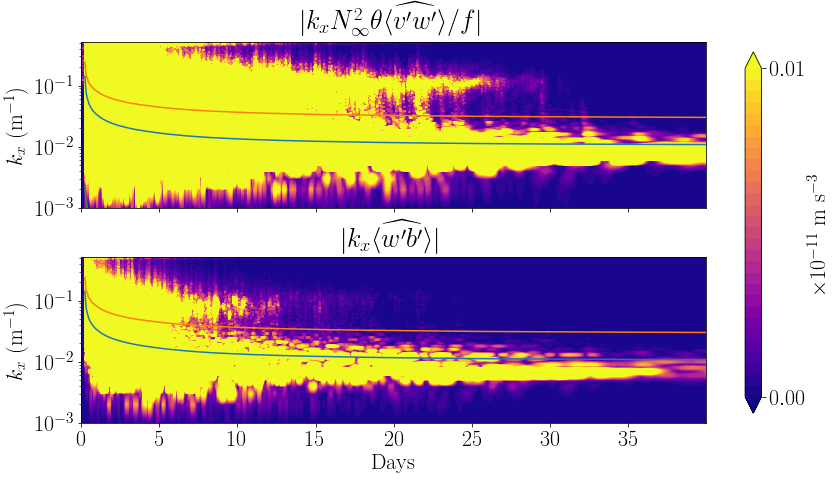

In [24]:
#%% v'w' and w'b' averaged over the BBL depth
cmin = -5e-12
cmax = -cmin
#cmin = 1e-4
#cmax = 1
cmin = 0
cmax = 1e-2
nc = 30
cm = 'plasma'
nt, nk, nz = wvs.shape
LScale = np.zeros((nt,))
wvsi = np.zeros((nk,nt))
wbsi = np.zeros((nk,nt))

for i in range(0,nt):
    #indl = np.argmin(np.abs(z-h[i]))
    indl = np.argmin(np.abs(z-0))
    indu = np.argmin(np.abs(z-H[i]))
    if indu <= indl:
        indu = indl+2
    zl = np.arange(indl, indu)
    SlopeI = np.arctan2(N**2*tht,N**2 + (bm[i,indu] - bm[i,indl])/(z[indu]-z[indl]))
    SlopeI = tht/S2
    LScale[i] = np.abs(0.65*H[i]/SlopeI)
    wvsi[:,i] = 1e11*np.abs((integrate.trapz(np.real(kx[np.newaxis,:]*wvs[i,:,zl]*N**2*tht/(1e-4))
                                                    ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    wbsi[:,i] = 1e11*np.abs((integrate.trapz(np.real(kx[np.newaxis,:]*wbs[i,:,zl])
                                                    ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    #wvsi[:,i] = np.abs((integrate.trapz(np.real(wvs[i,:,zl]*N**2*tht/(1e-4))
    #                                                ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
    #wbsi[:,i] = np.abs((integrate.trapz(np.real(wbs[i,:,zl])
    #                                                ,x=z[zl], axis=0))/(zm[zl[-1]]-zm[zl[0]]))
fig, ax = plt.subplots(2,1,sharex=True, figsize=(14,7))
ix = ax[0].contourf(time/86400, kx, (wvsi),np.linspace(cmin, cmax, nc), cmap = cm, vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[0].set_yscale('log')
ax[0].set_ylim((kx[1], kx[-1]))
ax[0].set_ylabel('$k_x$ (m$^{-1}$)')
ax[0].set_title(r'$|k_xN^2_\infty \theta \widehat{\langle v^\prime w^\prime\rangle}/f|$')
ax[0].plot(time/86400, 1/H)
ax[0].plot(time/86400, 1/h)
ax[0].plot(time/86400, 1/LScale)

ix = ax[1].contourf(time/86400, kx, (wbsi), np.linspace(cmin, cmax, nc), cmap = cm, vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[1].set_yscale('log')
ax[1].set_ylim((kx[1], kx[-1]))
ax[1].set_xlabel('Days')
ax[1].set_ylabel('$k_x$ (m$^{-1}$)')
ax[1].set_title('$|k_x\widehat{\langle w^\prime b^\prime\\rangle}|$')
ax[1].plot(time/86400, 1/H)
ax[1].plot(time/86400, 1/h)
#ax[1].plot(time/86400, 1/(0.35*H))
ax[1].plot(time/86400, 1/(LScale))
plt.subplots_adjust(hspace=0.3)

cb = fig.colorbar(ix, ax=ax.ravel().tolist(), shrink=0.95)
cb.set_ticks([cmin, cmax])
cb.set_label('$\\times 10^{-11}$ m s$^{-3}$')

#SAVEFLAG=True
#NameAppned = 'CI-1-LRG'
if SAVEFLAG:
    plt.savefig(f'./MSFigs/Spectrogram_{NameAppend}.pdf', bbox_inches='tight')


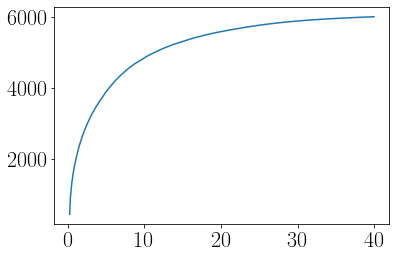

In [97]:
plt.plot(time/86400, LScale)

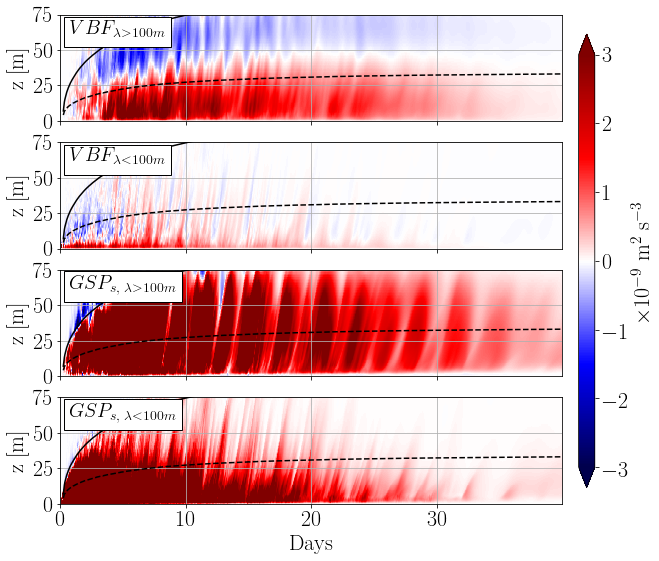

In [19]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

cmin = -3e-0
cmax = -cmin
zl = 75
zoff = 16
xoff = 0.75
cmap = 'Spectral_r'
cmap = 'seismic'
fig, ax = plt.subplots(4,1,sharex=True, figsize=(9,9))

im = ax[0].pcolormesh(time/86400, z, 1e9*np.transpose(vbfl), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[0].set_ylabel('z [m]')
ax[0].set_ylim(0, zl)
ax[0].plot(time/86400, H, color='k')
ax[0].plot(time/86400, h, color='k', linestyle='--')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(xoff,zl - zoff, '$VBF_{\lambda > 100m}$', fontsize=20, bbox=bb)
ax[0].set_yticks([0, 25, 50, 75])
ax[0].grid()

im = ax[1].pcolormesh(time/86400, z, 1e9*np.transpose(vbfh), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[1].set_ylabel('z [m]')
ax[1].set_ylim(0, zl)
ax[1].plot(time/86400, H, color='k')
ax[1].plot(time/86400, h, color='k', linestyle='--')
ax[1].text(xoff,zl - zoff, '$VBF_{\lambda < 100m}$', fontsize=20, bbox=bb)
ax[1].set_yticks([0, 25, 50, 75])
ax[1].grid()

im = ax[2].pcolormesh(time/86400, z, 1e9*np.transpose(gspl), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[2].set_ylabel('z [m]')
ax[2].set_ylim(0, zl)
ax[2].plot(time/86400, H, color='k')
ax[2].plot(time/86400, h, color='k', linestyle='--')
ax[2].text(xoff,zl - zoff, '$GSP_{s,\;\lambda > 100m}$', fontsize=20, bbox=bb)
ax[2].set_yticks([0, 25, 50, 75])
ax[2].grid()

im = ax[3].pcolormesh(time/86400, z, 1e9*np.transpose(gsph), vmin = cmin, vmax=cmax, cmap=cmap)
#im.set_edgecolor('face')
ax[3].set_ylabel('z [m]')
ax[3].set_ylim(0, zl)
ax[3].plot(time/86400, H, color='k')
#ax[3].plot(time/86400, hnum)
ax[3].plot(time/86400, h, color='k', linestyle='--')
ax[3].set_xlabel('Days')
ax[3].text(xoff,zl - zoff, '$GSP_{s,\;\lambda < 100m}$', fontsize=20, bbox=bb)
ax[3].set_yticks([0, 25, 50, 75])
ax[3].grid()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('$\\times 10^{-9}$ m$^2$ s$^{-3}$')

if SAVEFLAG:
    plt.savefig(f'./MSFigs/SpecFluxByDepth_{NameAppend}.pdf', bbox_inches='tight')


In [ ]:
ti = np.where((time/86400>10.) & (time/86400<12))[0] # Pick the time range to average over
#ti = np.where((time/86400>3.75) & (time/86400<4.25))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)


plt.plot(np.mean(gspl[ti,:], axis=0), z)
plt.plot(np.mean(gsph[ti,:], axis=0), z)
plt.plot(np.mean(vbfl[ti,:], axis=0), z)
plt.plot(np.mean(gspl[ti,:] + vbfl[ti,:], axis=0), z)

plt.axhline(hnum)
#plt.axhline(np.mean(Lo[ti]))
#plt.axhline(0.7*np.mean(us[ti]/1e-4), color='g')
plt.axvline(-np.mean(Beka[ti]))
plt.ylim(0,Hnum+10)

In [ ]:
ti = np.where((time/86400>10.) & (time/86400<12))[0] # Pick the time range to average over
#ti = np.where((time/86400>3.75) & (time/86400<4.25))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

vpwpl = gspl/(N**2*tht/1e-4)
vpwph = gsph/(N**2*tht/1e-4)
vzm = np.gradient(vm, axis=-1)/np.gradient(z)
plt.semilogx(np.mean(vpwpl[ti,:], axis=0)/np.mean(vzm[ti,:], axis=0), z)
plt.semilogx(np.mean(vpwph[ti,:], axis=0)/np.mean(vzm[ti,:], axis=0), z)

#plt.plot(np.mean(gsph[ti,:], axis=0), z)
#plt.plot(np.mean(vbfl[ti,:], axis=0), z)
#plt.plot(np.mean(gspl[ti,:] + vbfl[ti,:], axis=0), z)

plt.axhline(hnum)
#plt.axhline(np.mean(Lo[ti]))
#plt.axhline(0.7*np.mean(us[ti]/1e-4), color='g')
#plt.axvline(-np.mean(Beka[ti]))
plt.xlim(1e-5, 1e-2)
plt.ylim(0,Hnum+10)

In [ ]:
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
hscale = np.zeros((nt,))
gl = np.zeros((nt,))
gh = np.zeros((nt,))
for i in range(0, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfl[i,:],z)
    indh = np.argmin(np.abs(hnum[i]-z))
    gl[i] = gspl[i,indh]
    gh[i] = gsph[i,indh]
plt.semilogy(gl+gh)
plt.plot(N**2*tht/1e-4*us*(-Beka*hnum)**(1/3)*(4*0*(hnum/Hnum - 0.5)**2+1)*0.1)
plt.plot(N**2*tht/1e-4*us*(-Beka*hnum)**(1/3)*(4*(hnum/Hnum - 0.5)**2+1)*0.1)
#plt.plot(N**2*tht/1e-4*hnum*Vgz*(-Beka*hnum)**(1/3)*1e-2)

plt.ylim(1e-10,1e-8)

plt.figure()
plt.plot(hnum/Hnum)
plt.plot(Lo/Hnum)
plt.ylim(0,1)

In [ ]:
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
hscale = np.zeros((nt,))
gl = np.zeros((nt,))
gh = np.zeros((nt,))
for i in range(0, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z)
    ind = np.argmin(np.abs(hnum[i] - z))
    gl[i] = gspl[i,ind]
    gh[i] = gsph[i,ind]
    
fig, ax1 = plt.subplots()
ax1.semilogy(time/86400, gl, label='g low')
ax1.plot(time/86400, gh, label='g high')
ax1.plot(time/86400, gh+gl, label='sum')
Vgz = N**2*tht/(1e-4*(1+S2))
#ax1.plot(time/86400, Vgz*(2*us**2-0.0004*hnum**2*Vgz**2), label='scale')
#ax1.plot(time/86400, Vgz*(2*us*Hnum*Vgz-0.0004*hnum**2*Vgz**2), label='scale')
ax1.plot(time/86400, 1e-3*(1*us**2+0*Vgz*((0.5*Hnum-hnum)*Vgz*(-Beka*hnum)**(1/3))))
#ax1.plot(time/86400, Vgz*(Hnum-hnum)*Vgz*())
#ax1.semilogy(time/86400, 0.003*us**2, color='b')

#ax1.plot(time/86400, Vgz*(1*us*hnum*Vgz-0.1*hnum*Vgz*(-Beka*hnum)**(1/3)), label='scale')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.semilogy(time/86400, us**2, color='r')
ax1.set_ylim(1e-10, 1e-8)
ax1.legend()

In [ ]:
tn = time/86400
plt.plot(tn, hnum/Hnum)
plt.plot(tn, Lo/Hnum)
plt.plot(tn, 1.2*(Hnum*hnum)/(Hnum**2 + hnum**2))
plt.plot(tn, 1.4*(1/Hnum + 1/hnum)**(-1)/Hnum)

#plt.plot(tn, (1e-1*us*(-Beka*hnum)**(1/3))/((gl+gh)/Vgz))
#plt.plot(tn, 0.4*(gl+gh)/Vgz/us**2)
#plt.plot(tn, us/np.mean(us[0:18]))
plt.ylim(0, 1)

In [ ]:
print(vgz.shape)
plt.pcolor(time/86400, z, np.transpose(vgz/(N**2*tht/1e-4)), vmin=0, vmax=1)
plt.colorbar()
plt.plot(time/86400, hnum)
plt.plot(time/86400, Hnum)
plt.ylim(0, 100)

In [ ]:
vgzh = np.zeros((nt,))
for i in range(0,nt):
    ind = np.argmin(np.abs(hnum[i] - z))
    vgzh[i] = vgz[i,ind]
    
plt.plot(time/86400, vgzh/(N**2*tht/1e-4))
plt.axhline(1/(1+S2))

In [ ]:
upwph = np.zeros((nt,))
for i in range(0,nt):
    ind = np.argmin(np.abs(hnum[i] - z))
    upwph[i] = upwp[i,0,ind]
    
plt.plot(time/86400, (-upwph-taux/1030)/(1e-4*hnum))

In [ ]:
# Look at the absolute vertical vorticity
vgz = -bz_prime/1e-4*np.tan(tht)
vrelvort = -vgz*np.sin(tht)
vrelvort = -(np.gradient(vm, axis=-1)/np.gradient(z))*np.sin(tht)
plt.pcolor(time/86400, z, np.transpose(1e-4+vrelvort)/1e-4, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()
plt.xlim(0,40)

In [ ]:
#plt.plot(vrelvort[-1,:]/1e-4, z)

plt.plot(vgz[-1,:], z)
plt.plot(np.gradient(vm[-1,:])/np.gradient(z), z)

In [ ]:
fact = N**2*(1-1/(1+S2))
plt.pcolormesh(time/86400, z, np.transpose(bz/fact))
plt.colorbar()

plt.contour(time/86400, z, np.transpose(bz/fact), (1,), colors='w')

plt.xlim(0, 5)

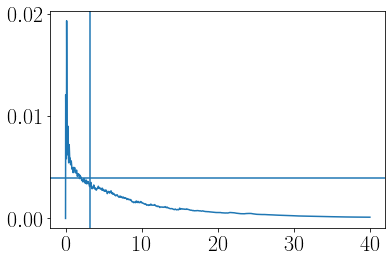

In [112]:
plt.plot(time/86400, -tauy/(1035*1e-4*(1+S2)))
plt.axhline(4*1e-4/tht)
plt.axvline(3.2)

In [140]:
def moving_average(a, n=24) :
    #ret = np.cumsum(a, dtype=float)
    #ret[n:] = ret[n:] - ret[:-n]
    #return ret[n - 1:] / n
    nt = a.shape[0]
    nchunks = np.floor(nt/n)

    split = np.array_split(a, nchunks)
    return np.asarray([np.mean(a) for a in split])
tauval = np.max(np.abs(moving_average(tauy)))

S = np.sqrt(S2)

Ns = np.sqrt(1e-6)
S = Ns*0.1/1e-4
Te = 0.1**2*(1+S**2)**2/(2*Ns*S**(3)*np.max(tauval/1035))
Te/86400
40/(Te/86400)



1.4845434835524387

In [ ]:
ti = np.where((time/86400>20.) & (time/86400<21))[0] # Pick the time range to average over
#ti = np.where((time/86400>3.75) & (time/86400<4.25))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

vo = np.mean(vm[ti,:], axis=0)
bo = np.mean(bm[ti,:], axis=0)
vxhat = - np.gradient(vo, axis=0)/np.gradient(z)*np.sin(tht)
vzhat = np.gradient(vo, axis=0)/np.gradient(z, axis=0)*np.cos(tht)
bzhat = (np.gradient(bo, axis=-1)/np.gradient(zo))*np.cos(tht)
bxhat = - np.gradient(bo, axis=0)/np.gradient(zo)*np.sin(tht)
vgz = bxhat/1e-4

plt.plot(vgz, z)
plt.axvline(N**2*tht/(1e-4*(1+S2)))
plt.axhline(hnum)

In [ ]:
ti = np.where((time/86400>11.) & (time/86400<13))[0] # Pick the time range to average over
#ti = np.where((time/86400>3.75) & (time/86400<4.25))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

vo = np.mean(vm[ti,:], axis=0)
bo = np.mean(bm[ti,:], axis=0)
vxhat = - np.gradient(vo, axis=0)/np.gradient(z)*np.sin(tht)
vzhat = np.gradient(vo, axis=0)/np.gradient(z, axis=0)*np.cos(tht)
bzhat = (np.gradient(bo, axis=-1)/np.gradient(zo))*np.cos(tht)
bxhat = - np.gradient(bo, axis=0)/np.gradient(zo)*np.sin(tht)
vgz = bxhat/1e-4


K = -np.mean(vpwp[ti,:], axis=0)/vzhat
Kg = -np.mean(vpwp[ti,:], axis=0)/vgz
Ks = -np.mean(vpwp[ti,:], axis=0)/(N**2*tht/(1e-4*(1+S2)))

plt.semilogx(K, z)
plt.semilogx(Kg, z)
plt.semilogx(Ks, z)
plt.xlim(1e-4, 1e-3)
plt.ylim(0,Hnum + 10)
plt.axhline(hnum)
plt.axhline(Hnum)

ki = np.zeros((nt,))
for i in range(0, nt):
    Hnum, hnum = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:] , z)

    indh = np.argmin(np.abs(hnum - z))
    ki[i] = -vpwp[i,indh]/np.mean(vz[i,:,:],axis=0)[indh]
    
plt.figure()   
plt.semilogy(time/86400, ki)



In [ ]:
#plt.scatter(ki, -(-Beka*h)**(1/3)*H*(1-4*(h/H-0.3)**2))
plt.scatter(ki, -(-Beka*h)**(1/3)*H*(h/H-2*(h/H)**2 + (h/H)**3))

#plt.ylim(0, 3e-3)
plt.xlim(0, 1e-2)

In [ ]:
ti = np.where((time/86400>21.) & (time/86400<23))[0] # Pick the time range to average over
#ti = np.where((time/86400>3.75) & (time/86400<4.25))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

vo = np.mean(vm[ti,:], axis=0)
bo = np.mean(bm[ti,:], axis=0)
vxhat = - np.gradient(vo, axis=0)/np.gradient(z)*np.sin(tht)
vzhat = np.gradient(vo, axis=0)/np.gradient(z, axis=0)*np.cos(tht)
bzhat = (np.gradient(bo, axis=-1)/np.gradient(zo))*np.cos(tht)
bxhat = - np.gradient(bo, axis=0)/np.gradient(zo)*np.sin(tht)
vgz = bxhat/1e-4


K = -np.mean(vpwp[ti,:], axis=0)/vzhat
Kg = -np.mean(vpwp[ti,:], axis=0)/vgz
Ks = -np.mean(vpwp[ti,:], axis=0)/(N**2*tht/(1e-4*(1+S2)))

plt.plot(K, z)
sig = z/Hnum
plt.plot(np.max(K[0:100])*(sig - 2*sig**2 + sig**3), z)
plt.ylim(0, 50)
plt.xlim(0, np.max(K[0:100]))

In [ ]:
bxhat = -(np.gradient(bm, axis=-1)/np.gradient(z))*np.sin(tht)
vzm = np.gradient(vm, axis=-1)/np.gradient(z)
vgzi = np.zeros((nt,))
vzti = np.zeros((nt,))
for i in range(0,nt):
    Hnum, hnum = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:], z)
    indh = np.argmin(np.abs(hnum-z))
    vgzi[i] = bxhat[i,indh]/1e-4
    vzti[i] = vzm[i,indh]
    
tn = time/86400
#plt.plot(tn, vgzi)
#plt.plot(tn, vzti)
plt.plot(tn, vgzi/vzti)
#plt.axhline(N**2*tht/(1e-4*(1+S2)))
plt.ylim(0, 2)



In [ ]:
vm.shape

In [ ]:
ti = np.where((time/86400>11.) & (time/86400<13))[0] # Pick the time range to average over
#ti = np.where((time/86400>3.75) & (time/86400<4.25))[0] # Pick the time range to average over
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0) , z)

vo = np.mean(vm[ti,:], axis=0)
bo = np.mean(bm[ti,:], axis=0)
vxhat = - np.gradient(vo, axis=0)/np.gradient(z)*np.sin(tht)
vzhat = np.gradient(vo, axis=0)/np.gradient(z, axis=0)*np.cos(tht)
bzhat = (np.gradient(bo, axis=-1)/np.gradient(zo))*np.cos(tht)
bxhat = - np.gradient(bo, axis=0)/np.gradient(zo)*np.sin(tht)
vgz = bxhat/1e-4
vg = integrate.cumtrapz(vgz, x=zo, axis=-1, initial=0)
vg = vg-vg[-1]
vgx = - np.gradient(vg, axis=0)/np.gradient(zo)*np.sin(tht)
vort = (1e-4+vxhat)*bzhat 

plt.plot(vgx/1e-4, z)
plt.plot(vxhat/1e-4, z)
plt.plot(bxhat/(N**2*tht), z)
plt.axhline(Hnum)
plt.axhline(hnum)
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.grid()

In [ ]:
vpwp.shape

In [ ]:
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
hscale = np.zeros((nt,))
vz = np.gradient(vm, axis=-1)/np.gradient(z)
Vgz = N**2*tht/(1e-4*(1+S2))
vph = np.zeros((nt,))
nuh = np.zeros((nt,))
for i in range(0, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfrot[i,0,:],z)
    ind = np.argmin(np.abs(hnum[i] - z))
    vph[i] = vpwp[i, ind]
    nuh[i] = 1e-4*vz[i,ind]
    
plt.plot(time/86400, (hnum/Hnum)**(4/3))
#plt.plot(time/86400, np.sqrt(np.abs(nuh/us**2)))
plt.plot(time/86400, (1e-4)/((-Beka)**(1/3)*Hnum**(4/3)*Vgz))

# Assume that vpwp ~ h^2 vgz^2

#plt.plot(time/86400, (1e-4*Vgz/(Hnum*Vgz*us)))
plt.ylim(0, 1)


1.0073958486714956


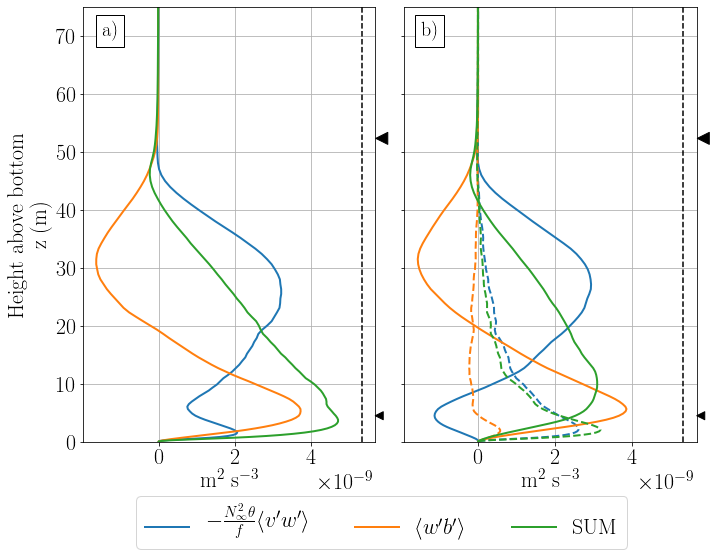

In [221]:
# Plot the mean across and along slope momentum budget
ti = np.where((time/86400>11) & (time/86400<13))[0] # Pick the time range to average over
#ti = np.where((time/86400>6) & (time/86400<8))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.75)
#hap = findHScale(np.mean(H[ti]), np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), 1 + 0*Hnum)
hap = findHScale(np.mean(H[ti]), np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti]), np.mean(vbfrot[ti,0,:], axis=0), z, S2)


fig, axs = plt.subplots(1,2,figsize=(11,8),sharey=True)

# DIRECT FLUXES
ax = axs[0]
GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
#VBF = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)

ax.plot(GSP, z, label=r'$-\frac{N^2_\infty \theta}{f}\langle v^\prime w^\prime \rangle$', linewidth=2)
ax.plot(VBF, z, label=r'$\langle w^\prime b^\prime \rangle$', linewidth=2)
ax.plot(GSP+VBF, z, label='SUM', linewidth=2)
#ax.plot(np.mean(wq[ti,0,:], axis=0)*1e4, z)
ax.axvline(-np.mean((1+S2)*Beka[ti]), linestyle='--', color='k')
#ax.axhline(np.mean(H[ti]))
ax.set_ylim(0, 75)
ax.set_ylabel('Height above bottom\n z (m)')
ax.legend(ncol = 3, bbox_to_anchor=(1.9, -0.1))
ax.grid()
ax.set_xlabel('m$^2$ s$^{-3}$')
xlims = ax.get_xlim()
#ax.plot(xlims[-1], hap, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)
#ax.plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.annotate('', xy=(xlims[-1], Hnum), xytext=(1.05*xlims[-1], Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('', xy=(xlims[-1], hnum), xytext=(1.015*xlims[-1], hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(xlims)
bb = dict(boxstyle='Square', fc='w')
ax.text(-1.5e-9,70, 'a)', fontsize=20, bbox=bb)


# SPECTRAL FLUXES
GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
CSP = N**2*tht/(1e-4*(1+S2))*np.mean(upwp[ti,0,:], axis=0)

HBF = np.mean(hbfr[ti,0,:], axis=0)

#VBF = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)
ax = axs[1]
ax.plot(np.mean(gspl[ti,:], axis=0), z, label=r'$-\frac{N^2_\infty \theta}{f}\langle v^\prime w^\prime \rangle_{\lambda_x > 100\;\mathrm{m}}$', linewidth=2, color='#1f77b4')
ax.plot(np.mean(gsph[ti,:], axis=0), z, label=r'$GSP_{\lambda_x<100m}$', linewidth=2,linestyle='--', color='#1f77b4')

ax.plot(np.mean(vbfl[ti,:], axis=0), z, label=r'$VBF_{\lambda_x>100m}$', linewidth=2, color='#ff7f0e')
ax.plot(np.mean(vbfh[ti,:], axis=0), z, label=r'$VBF_{\lambda_x<100m}$', linewidth=2, linestyle='--',color='#ff7f0e')

#ax.plot(HBF, z, label=r'$\langle u^\prime b^\prime \rangle$', linewidth=2)

#ax.plot(np.mean(gspl[ti,:]+gsph[ti,:]+vbfl[ti,:]+vbfh[ti,:], axis=0), z, label='SUM', linewidth=1, linestyle='--', color='0.5')
ax.plot(np.mean(gspl[ti,:]+vbfl[ti,:], axis=0), z, label='SUM', linewidth=2,  color='#2ca02c')
ax.plot(np.mean(gsph[ti,:]+vbfh[ti,:], axis=0), z, label='SUM', linewidth=2,linestyle='--',color='#2ca02c')
#ax.plot(np.mean(gsph[ti,:]+gspl[ti,:]+vbfl[ti,:]+vbfh[ti,:], axis=0), z, label='SUM', linewidth=2,linestyle='--',color='#2ca02c')

#ax.plot(np.mean(wq[ti,0,:], axis=0)*1e4, z)
ax.axvline(-np.mean((1+S2)*Beka[ti]), linestyle='--', color='k')
#ax.axhline(np.mean(H[ti]))
ax.set_ylim(0, 75)
#ax.set_ylabel('Height above bottom\n z (m)')
#ax.legend()
ax.grid()
ax.set_xlabel('m$^2$ s$^{-3}$')
xlims = ax.get_xlim()
#ax.plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.annotate('', xy=(xlims[-1], Hnum), xytext=(1.05*xlims[-1], Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('', xy=(xlims[-1], hnum), xytext=(1.015*xlims[-1], hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#ax.plot(xlims[-1], hap, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)
ax.text(-1.5e-9,70, 'b)', fontsize=20, bbox=bb)

#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(xlims)
plt.subplots_adjust(wspace=0.1)
#SAVEFLAG=True
vsmooth = np.mean(vbfh[ti,:], axis=0)
indmax = np.argmax(vsmooth)
inds = np.where(np.logical_and(vsmooth<0.05*np.max(vsmooth), z>z[indmax]))[0] 
#plt.axhline(z[inds[0]])
#SAVEFLAG = True
if SAVEFLAG:
    plt.savefig(f'./MSFigs/FLUXLOWHIGH_{NameAppend}.pdf', bbox_inches='tight')

1.0119626679331992


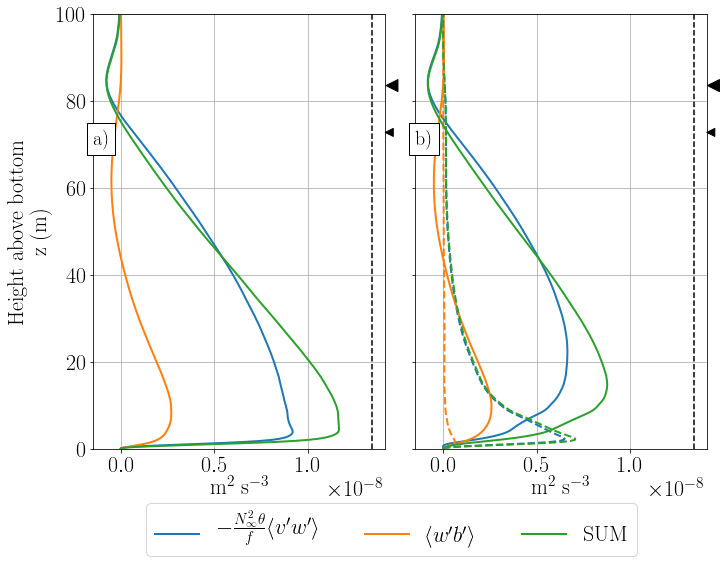

In [94]:
# Plot the mean across and along slope momentum budget --- TESTING NOT THE MS VERSION


ti = np.where((time/86400>11) & (time/86400<13))[0] # Pick the time range to average over
#ti = np.where((time/86400>3) & (time/86400<4))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z)
#hap = findHScale(np.mean(H[ti]), np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), 1 + 0*Hnum)
hap = findHScale(np.mean(H[ti]), np.sqrt(np.mean(-tauy[ti])/1030), N**2*tht/(1e-4*(1+S2)), np.mean(Beka[ti]), np.mean(vbfrot[ti,0,:], axis=0), z, S2)


fig, axs = plt.subplots(1,2,figsize=(11,8),sharey=True)

# DIRECT FLUXES
ax = axs[0]
GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
#VBF = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)

ax.plot(GSP, z, label=r'$-\frac{N^2_\infty \theta}{f}\langle v^\prime w^\prime \rangle$', linewidth=2)
ax.plot(VBF, z, label=r'$\langle w^\prime b^\prime \rangle$', linewidth=2)
ax.plot(GSP+VBF, z, label='SUM', linewidth=2)
#ax.plot(np.mean(wq[ti,0,:], axis=0)*1e4, z)
ax.axvline(-np.mean((1+S2)*Beka[ti]), linestyle='--', color='k')
#ax.axhline(np.mean(H[ti]))
ax.set_ylim(0, 100)
ax.set_ylabel('Height above bottom\n z (m)')
ax.legend(ncol = 3, bbox_to_anchor=(1.9, -0.1))
ax.grid()
ax.set_xlabel('m$^2$ s$^{-3}$')
xlims = ax.get_xlim()
#ax.plot(xlims[-1], hap, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)
#ax.plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.annotate('', xy=(xlims[-1], Hnum), xytext=(1.05*xlims[-1], Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('', xy=(xlims[-1], hnum), xytext=(1.015*xlims[-1], hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(xlims)
bb = dict(boxstyle='Square', fc='w')
ax.text(-1.5e-9,70, 'a)', fontsize=20, bbox=bb)


# SPECTRAL FLUXES
GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
CSP = N**2*tht/(1e-4*(1+S2))*np.mean(upwp[ti,0,:], axis=0)

HBF = np.mean(hbfr[ti,0,:], axis=0)

#VBF = np.gradient(np.mean(vbfrot[ti,0,:], axis=0))/np.gradient(z)
ax = axs[1]
ax.plot(np.mean(gspl[ti,:], axis=0), z, label=r'$-\frac{N^2_\infty \theta}{f}\langle v^\prime w^\prime \rangle_{\lambda_x > 100\;\mathrm{m}}$', linewidth=2, color='#1f77b4')
ax.plot(np.mean(gsph[ti,:], axis=0), z, label=r'$GSP_{\lambda_x<100m}$', linewidth=2,linestyle='--', color='#1f77b4')

ax.plot(np.mean(vbfl[ti,:], axis=0), z, label=r'$VBF_{\lambda_x>100m}$', linewidth=2, color='#ff7f0e')
ax.plot(np.mean(vbfh[ti,:], axis=0), z, label=r'$VBF_{\lambda_x<100m}$', linewidth=2, linestyle='--',color='#ff7f0e')

#ax.plot(HBF, z, label=r'$\langle u^\prime b^\prime \rangle$', linewidth=2)

#ax.plot(np.mean(gspl[ti,:]+gsph[ti,:]+vbfl[ti,:]+vbfh[ti,:], axis=0), z, label='SUM', linewidth=1, linestyle='--', color='0.5')
ax.plot(np.mean(gspl[ti,:]+vbfl[ti,:], axis=0), z, label='SUM', linewidth=2,  color='#2ca02c')
ax.plot(np.mean(gsph[ti,:]+vbfh[ti,:], axis=0), z, label='SUM', linewidth=2,linestyle='--',color='#2ca02c')
#ax.plot(np.mean(gsph[ti,:]+gspl[ti,:]+vbfl[ti,:]+vbfh[ti,:], axis=0), z, label='SUM', linewidth=2,linestyle='--',color='#2ca02c')

#ax.plot(np.mean(wq[ti,0,:], axis=0)*1e4, z)
ax.axvline(-np.mean((1+S2)*Beka[ti]), linestyle='--', color='k')
#ax.axhline(np.mean(H[ti]))
#ax.set_ylim(0, 75)
#ax.set_ylabel('Height above bottom\n z (m)')
#ax.legend()
ax.grid()
ax.set_xlabel('m$^2$ s$^{-3}$')
xlims = ax.get_xlim()
#ax.plot(xlims[-1], hnum, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.annotate('', xy=(xlims[-1], Hnum), xytext=(1.05*xlims[-1], Hnum),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('', xy=(xlims[-1], hnum), xytext=(1.015*xlims[-1], hnum),
            arrowprops=dict(facecolor='black', headwidth=8, headlength=8),
            )
#ax.plot(xlims[-1], hap, marker='<', color='w', markeredgecolor='k', markersize=15)
#ax.plot(xlims[-1], np.mean(H[ti]), marker='<', color='w', markeredgecolor='k', markersize=20)
ax.text(-1.5e-9,70, 'b)', fontsize=20, bbox=bb)

#ax.plot(1000, Hnum, marker='<', color='w', markeredgecolor='k', markersize=20)
ax.set_xlim(xlims)
plt.subplots_adjust(wspace=0.1)
#SAVEFLAG=True
vsmooth = np.mean(vbfh[ti,:], axis=0)
indmax = np.argmax(vsmooth)
inds = np.where(np.logical_and(vsmooth<0.05*np.max(vsmooth), z>z[indmax]))[0] 
#plt.axhline(z[inds[0]])
#SAVEFLAG = True
if SAVEFLAG:
    plt.savefig(f'./MSFigs/FLUXLOWHIGH_{NameAppend}.pdf', bbox_inches='tight')

58.91568289420961
29.724525554277477


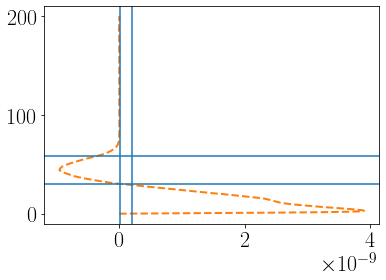

In [145]:
ti = np.where((time/86400>4) & (time/86400<40))[0] # Pick the time range to average over
ti = ti[0] # Pick the time range to average over
toff = 18*2
ti = range(ti,ti+toff)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z)
print(Hnum)
print(hnum)

plt.plot(np.mean(vbfh[ti,:], axis=0), z, label=r'$VBF_{\lambda_x<100m}$', linewidth=2, linestyle='--',color='#ff7f0e')
mv = np.max(np.mean(vbfh[ti,:], axis=0))
#plt.axvline(1e-4*N**2)
plt.axvline(0.05*mv)
plt.axvline(0.01*1e-4*N**2)
plt.axhline(hnum)
plt.axhline(Hnum)

In [ ]:
Hnum = np.zeros((nt,))
hnum = np.zeros((nt,))
hscale = np.zeros((nt,))
ent = np.zeros((nt,))
vh = np.zeros((nt,))
uh = np.zeros((nt,))

for i in range(0, nt):
    Hnum[i], hnum[i] = findH(qm[i,:], 1e-4*N**2, vbfh[i,:],z)
    
plt.semilogy(hnum/Hnum)
plt.plot(2*us/(Hnum*Vgz))

plt.figure()
plt.scatter(hnum/Hnum, us/(Hnum*Vgz))

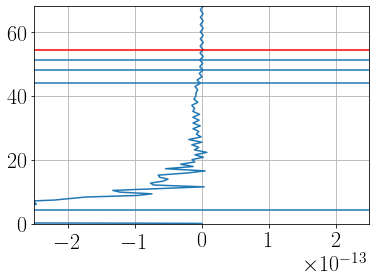

In [219]:
ti = np.where((time/86400>10) & (time/86400<13))[0] # Pick the time range to average over
#ti = np.where((time/86400>3) & (time/86400<6))[0] # Pick the time range to average over

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfrot[ti,0,:], axis=0), z)

plt.plot(np.mean(wq[ti,0,:], axis=0), z)
plt.ylim(0, Hnum+20)
plt.xlim(-0.25e-12,0.25e-12)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.5)
plt.axhline(Hnum)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.75)
plt.axhline(Hnum)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.25)
plt.axhline(Hnum)

Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.9)
plt.axhline(Hnum, color='r')
plt.axhline(hnum)
plt.grid()

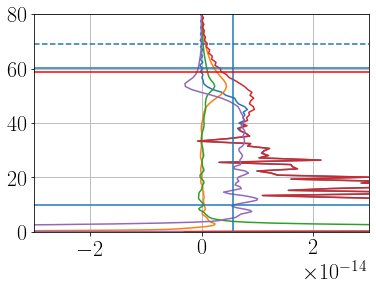

In [296]:
# LOOK AT ALL THE PV FLUX TERMS
ti = np.where((time/86400>20) & (time/86400<22))[0] # Pick the time range to average over

bza = np.mean(bz[ti,:], axis=0)
bzz = np.gradient(bza)/np.gradient(z)
vxm = -np.gradient(np.mean(vm[ti,:], axis=0), axis=0)/np.gradient(z)*tht
vz = np.gradient(np.mean(vm[ti,:], axis=0))/np.gradient(z)
vzz = np.gradient(vz)/np.gradient(z)
Jf = N**2*tht*1e-4*vzz
Jb = -(1e-4+vxm)*1e-4*bzz
Ja = np.mean(wq[ti,0,:], axis=0)
GSP = np.mean(-gspr[ti,0,:], axis=0)
#GSP = np.gradient(np.mean(-gspr[ti,0,:], axis=0))/np.gradient(z)
VBF = np.mean(vbfrot[ti,0,:], axis=0)
qwtheory = 1e-4*np.gradient(GSP + VBF)/np.gradient(z)

plt.plot(-Ja, z)
plt.plot(-Jb, z)
plt.plot(-Jf, z)
plt.plot(-(Ja+Jb+Jf), z)
plt.plot(-qwtheory, z)
plt.ylim(0, 80)
plt.xlim(-3e-14, 3e-14)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.75)
plt.axhline(Hnum)
plt.axhline(hnum)
plt.axvline(-1e-4*(1+S2)*np.mean(Beka[ti])/Hnum)
Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.95)
plt.axhline(Hnum, linestyle='--')
hind = np.where(np.mean(qbulknz[ti,:], axis=0)>0)[0]
plt.axhline(z[hind[0]], color='r')
plt.grid()

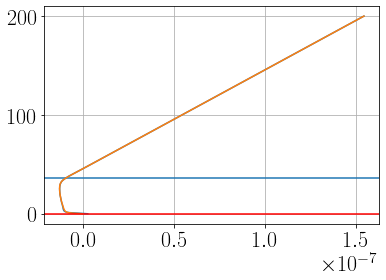

In [306]:
ti = np.where((time/86400>3) & (time/86400<5))[0] # Pick the time range to average over


Hnum, hnum = findH(np.mean(qm[ti,:], axis=0), 1e-4*N**2, np.mean(vbfh[ti,:], axis=0), z, crit=0.75)
plt.axhline(Hnum)

plt.plot(np.mean(qbulk[ti,:], axis=0), z)
plt.plot(np.mean(qbulknz[ti,:], axis=0), z)

hind = np.where(np.mean(qbulknz[ti,:], axis=0)>0)[0]
plt.axhline(z[hind[0]], color='r')
plt.grid()

In [285]:
zetap = np.gradient(v, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
bp = b - bm[:,np.newaxis,:]
zb = np.mean(zetap*bp, axis=1)
qbulk = 1e-4*(bm - bm[:,0][:,np.newaxis]) + 1e-4*N**2*z - N**2*tht*(vm + Vi) + np.gradient(zb, axis=-1)/np.gradient(z)
qbulknz = 1e-4*(bm - bm[:,0][:,np.newaxis]) + 1e-4*N**2*z - N**2*tht*(vm + Vi)
zetap.shape

(1920, 1024, 256)

No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 
No Ind 


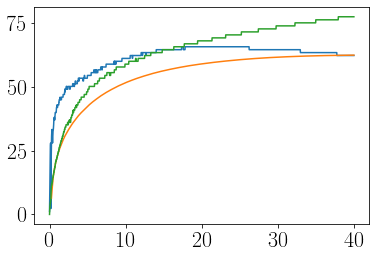

In [649]:
Hpv = np.zeros((nt,))
Hnuma = np.zeros((nt,))
for i in range(0, nt):
    #zind = np.where(np.logical_and(qbulknz[i,:]>0, z>z[zoff]))[0]
    zind = np.where(np.logical_and(qbulknz[i,:]>0, z>z[off]))[0]

    #zind = np.where(qm[i,:]>0)[0]
    Hpv[i] = z[zind[0]]
    Hnuma[i], hnum = findH(qm[i,:], 1e-4*N**2, vbfh[ti,:], z, crit=0.75)

    
plt.plot(time/86400, Hpv)
plt.plot(time/86400,H)
plt.plot(time/86400,Hnuma)

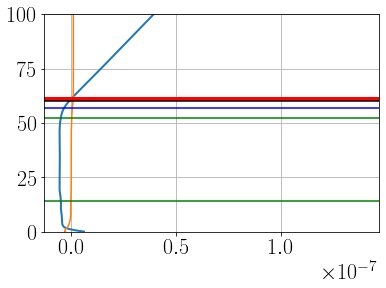

In [647]:
ti = 500
dvisc = 100*1e-4/us[ti]
#off = np.argmin(np.abs(z-dvisc))
off = 11
qbulknz = (1e-4*(bm - bm[:,off][:,np.newaxis]) + 1e-4*N**2*(z-z[off]) - N**2*tht*(vm - vm[:,off][:,np.newaxis]))
#qbulknz = (1e-4*(bm - bm[:,off][:,np.newaxis]) + 1e-4*N**2*(z-z[off]) - 1e-4*N**2*tht*(N**2*tht/(1e-4*(1+S2))*z))
#qbulknz = 1e-4*(bm - bm[:,off][:,np.newaxis]) + 1e-4*N**2*(z-z[off]) - N**2*tht*(vm  - vm[:,off][:,np.newaxis]) + (zb - zb[:,off][:,np.newaxis])

#qbulknz = (1e-4 - tht*(vm+Vi))*(bm-bm[:,off][:,np.newaxis] + N**2*(z-z[off])) - N**2*tht*(v)

#zind = np.where(qbulknz[ti,:]>1e-4*N**2)[0]
zind = np.where(np.logical_and(qbulknz[ti,:]>0, z>z[off]))[0]
plt.plot(qbulknz[ti,:], z, linewidth=2)
plt.plot(qm[ti,:], z)
#plt.plot(integrate.cumtrapz(qm[ti,:], x=z, initial=0), z, linestyle='--')
plt.axhline(z[zind[0]], color='r', linewidth=4)
plt.axhline(H[ti], color='g')
Hnum, hnum = findH(qm[ti,:], 1e-4*N**2, vbfh[ti,:], z, crit=0.5)
plt.axhline(Hnum, color='b')
Hnum, hnum = findH(qm[ti,:], 1e-4*N**2, vbfh[ti,:], z, crit=0.75)
plt.axhline(Hnum, color='k')
plt.axhline(hnum, color='g')
plt.ylim(0, 100)
plt.grid()


In [313]:
qbulknz = 1e-4*(bm - bm[:,0][:,np.newaxis]) + 1e-4*N**2*z - N**2*tht*(vm + Vi)

np.where(np.mean(qbulknz[100,:], axis=0)>0)

(array([0]),)

In [605]:
z[zind[0]]

55.58778554295707

In [579]:
z[off]

2.8496109013748168

In [614]:
zb[:,1]

array([ 0.00000000e+00,  8.67450740e-15, -1.42391853e-16, ...,
        1.03577737e-11,  1.06649340e-11,  1.10354398e-11])

In [615]:
zetap.shape

(1920, 1024, 256)